# COVID-19 Mitigation Measures Collateral Damage Assesment 

In this project i will determine which factors are most relevant for the reprodduction of the SARS-CoV2 virus in Austria, built a SIR-based model to simulate various scenarios for different stringency of mitigation measures and then try to estimate the collateral damage by said measures. End product is an estimate for collateral damage of measures and effectiveness in containing the virus

In [1]:
import os
import requests
from pprint import pprint
import covsirphy as cs
import pandas as pd
import numpy as np
import datetime
from operator import add

import scipy.stats as st
from scipy.optimize import curve_fit
from scipy.integrate import odeint
from scipy.stats import ttest_ind
from scipy import signal
from scipy.stats import boxcox

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from statsmodels.sandbox.regression.predstd import wls_prediction_std

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import SelectKBest
from sklearn.metrics import r2_score, mean_squared_error, explained_variance_score, mean_squared_log_error


import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
sns.set(rc={'figure.figsize':(15.7,10.27*0.75)})

In [2]:
# Some Sources:
# https://www.who.int/bulletin/online_first/BLT.20.265892.pdf
# https://www.imperial.ac.uk/media/imperial-college/medicine/mrc-gida/2020-03-16-COVID19-Report-9.pdf
# https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7333368/

## 1. Data Preparation and Exploration

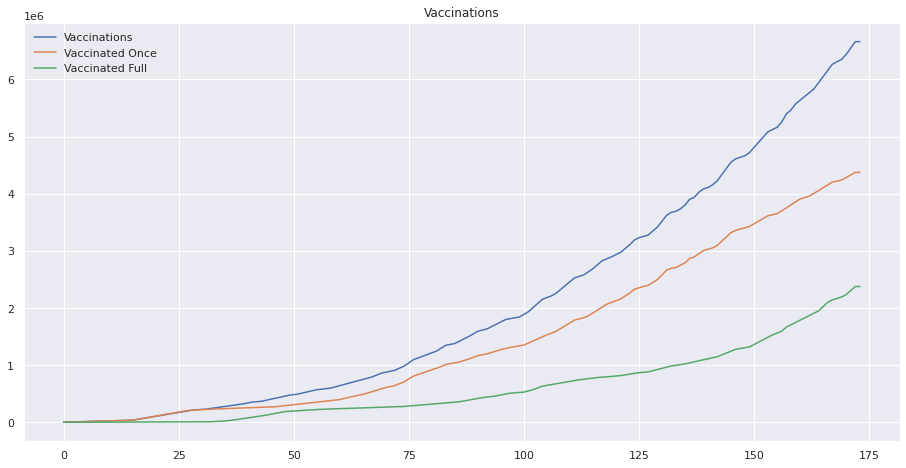

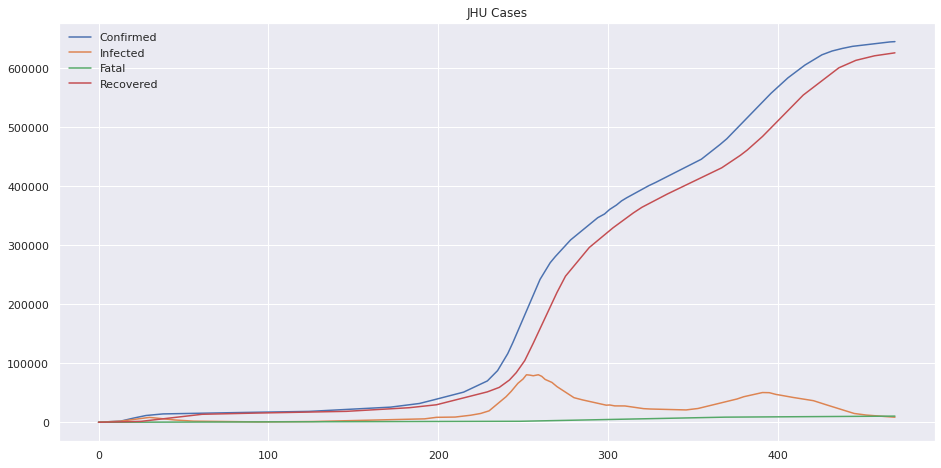

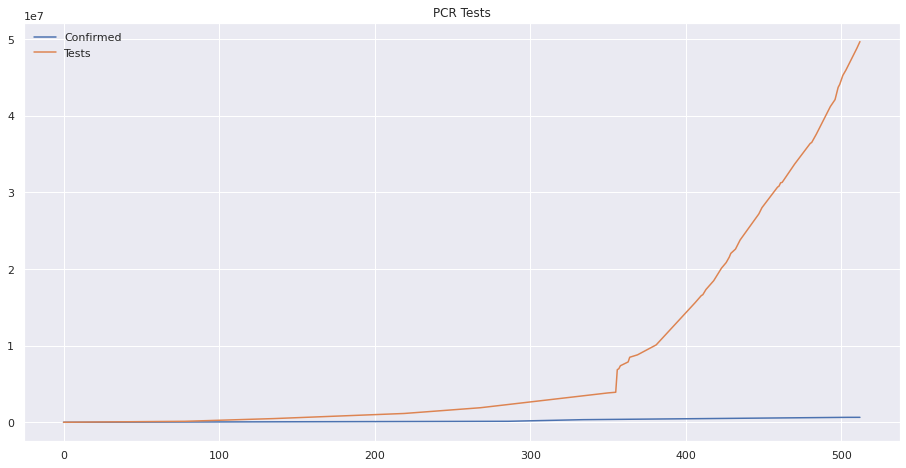

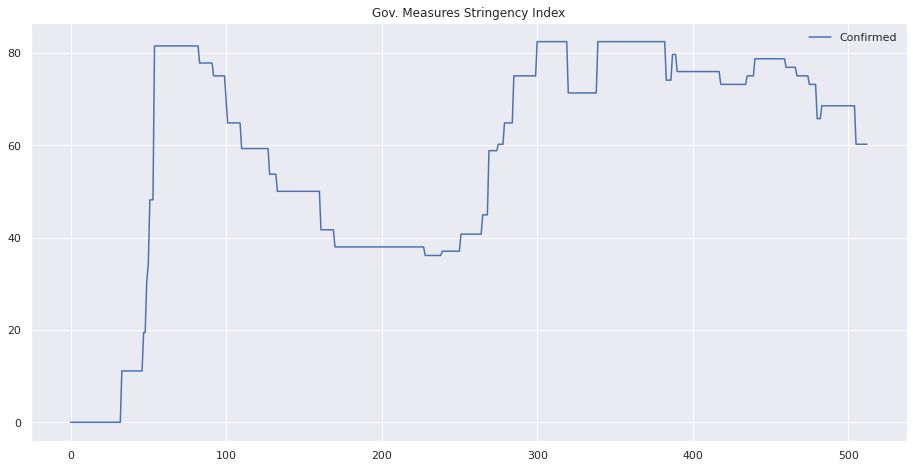

In [3]:
#Get data
data_loader = cs.DataLoader("../input")
jhu_data = data_loader.jhu() #Cases (JHU)
population_data = data_loader.population() # Population
oxcgrt_data = data_loader.oxcgrt() # Government Response (OxCGRT)
pcr_data = data_loader.pcr() # Tests
vaccine_data = data_loader.vaccine() # Vaccinations
#print(vaccine_data.subset("Austria"))
plt.plot(vaccine_data.subset("Austria")['Vaccinations'], label='Vaccinations')
plt.plot(vaccine_data.subset("Austria")['Vaccinated_once'], label='Vaccinated Once')
plt.plot(vaccine_data.subset("Austria")['Vaccinated_full'], label='Vaccinated Full')
plt.title('Vaccinations')
plt.legend()
plt.show()

#print(jhu_data.subset("Austria"))
plt.plot(jhu_data.subset("Austria")['Confirmed'], label='Confirmed')
plt.plot(jhu_data.subset("Austria")['Infected'], label='Infected')
plt.plot(jhu_data.subset("Austria")['Fatal'], label='Fatal')
plt.plot(jhu_data.subset("Austria")['Recovered'], label='Recovered')
plt.title('JHU Cases')
plt.legend()
plt.show()

#print(pcr_data.subset("Austria"))
plt.plot(pcr_data.subset("Austria")['Confirmed'], label='Confirmed')
plt.plot(pcr_data.subset("Austria")['Tests'], label='Tests')
plt.title('PCR Tests')
plt.legend()
plt.show()

#print(oxcgrt_data.subset("Austria"))
plt.plot(oxcgrt_data.subset("Austria")['Stringency_index'], label='Confirmed')
plt.title('Gov. Measures Stringency Index')
plt.legend()
plt.show()

country = "Austria"
aut_cov = jhu_data.subset("Austria")
aut_pop = population_data.subset("Austria")
aut_gov = oxcgrt_data.subset("Austria")
aut_pcr = pcr_data.subset("Austria")
aut_vac = vaccine_data.subset("Austria") 

age 0 to 9
age 10 to 19
age 20 to 29
age 30 to 39
age 40 to 49
age 50 to 59
age 60 to 69
age 70 to 79
age 80 to 89
age 90 to 99
age 100 to 109
8901064
                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.933
Model:                            OLS   Adj. R-squared (uncentered):              0.914
Method:                 Least Squares   F-statistic:                              49.00
Date:                Fri, 18 Jun 2021   Prob (F-statistic):                    7.65e-05
Time:                        20:13:01   Log-Likelihood:                          17.143
No. Observations:                   9   AIC:                                     -30.29
Df Residuals:                       7   BIC:                                     -29.89
Df Model:                           2                                                  
Covariance Type:            nonrobust                    

/media/lorenz/Volume/ubuntu/anaconda3/envs/p2/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


AltersgruppeID
1        [<5]
2      [5-14]
3     [15-24]
4     [25-34]
5     [35-44]
6     [45-54]
7     [55-64]
8     [65-74]
9     [75-84]
10      [>84]
Name: Altersgruppe, dtype: object
                Anzahl AnzahlGeheilt AnzahlTot AnzEinwohner Altersgruppe  \
AltersgruppeID                                                             
1                 8301          8145         0       435835         [<5]   
2                50745         50085         2       847225       [5-14]   
3                93182         91922         7       955625      [15-24]   
4               104019        102714        13      1209030      [25-34]   
5                97687         96474        32      1174745      [35-44]   
6               111565        110159       163      1333857      [45-54]   
7                84786         83159       608      1251120      [55-64]   
8                40772         38531      1506       842035      [65-74]   
9                33170         28951      3549     

/media/lorenz/Volume/ubuntu/anaconda3/envs/p2/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


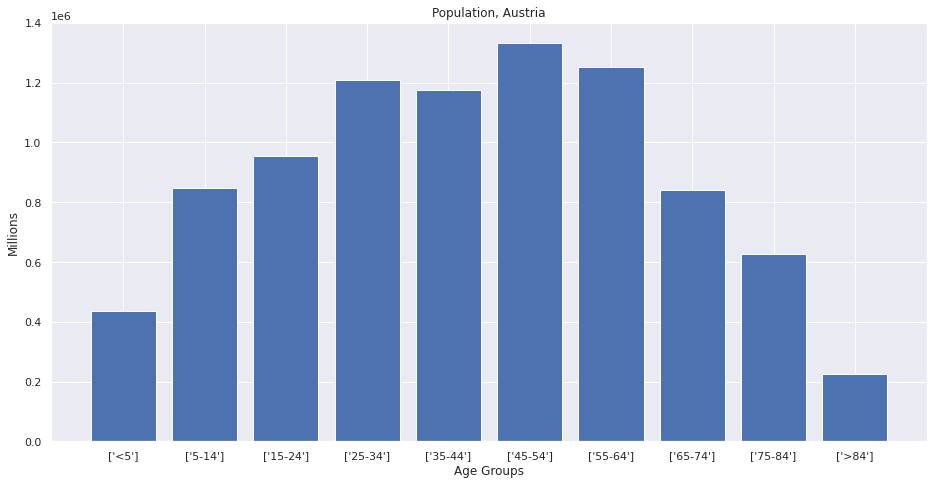

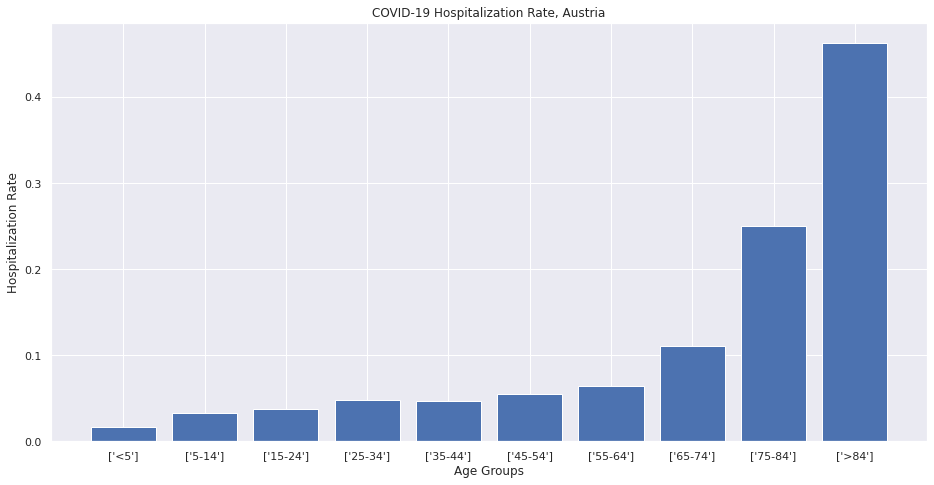

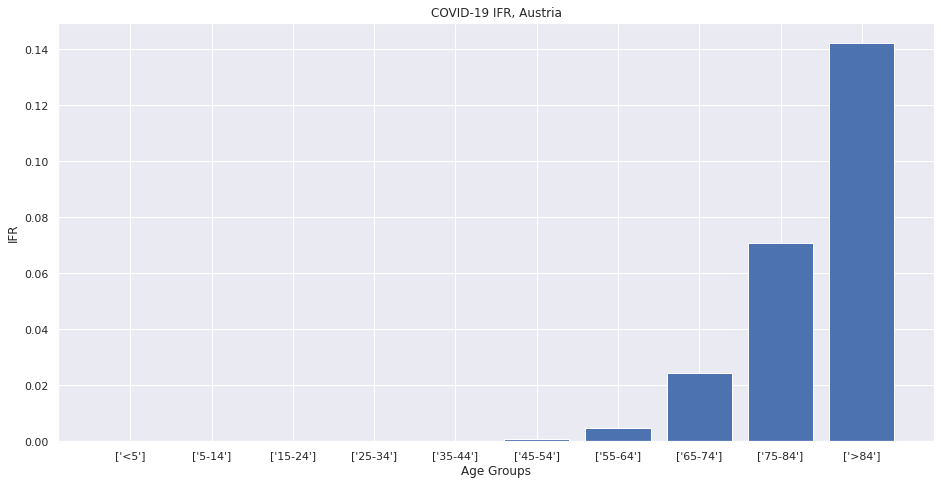

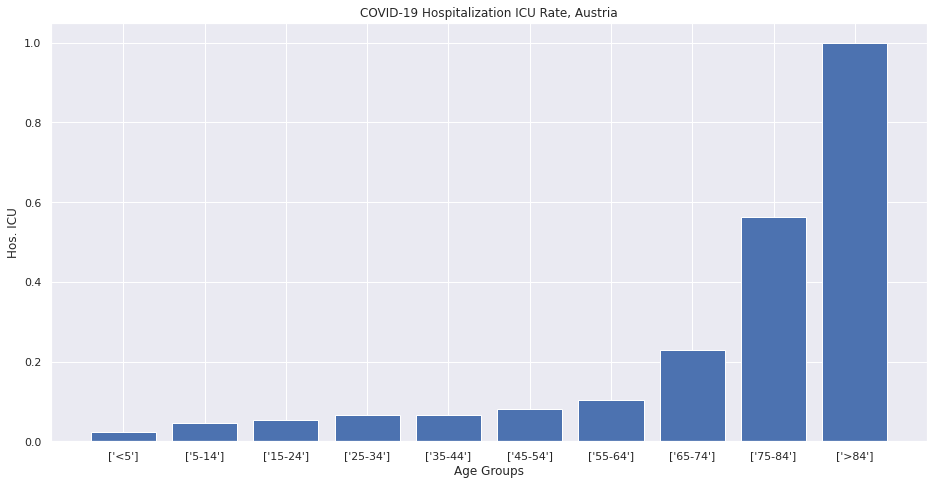

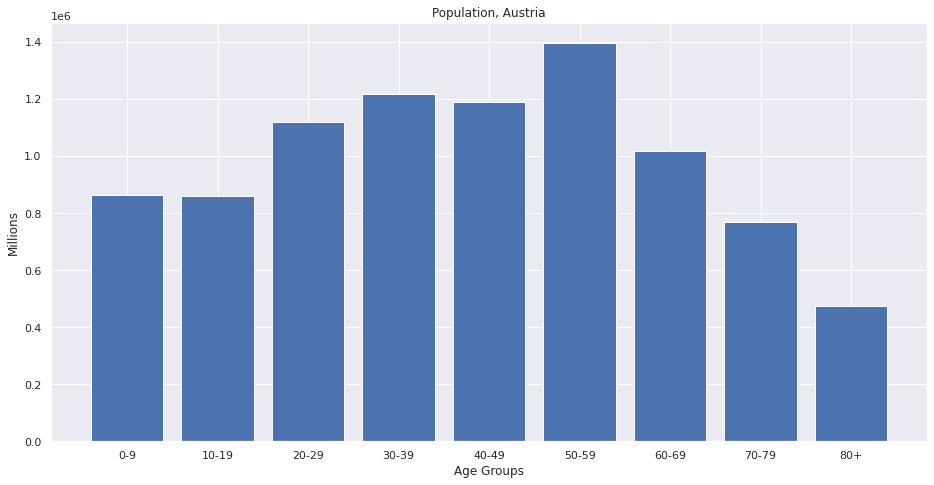

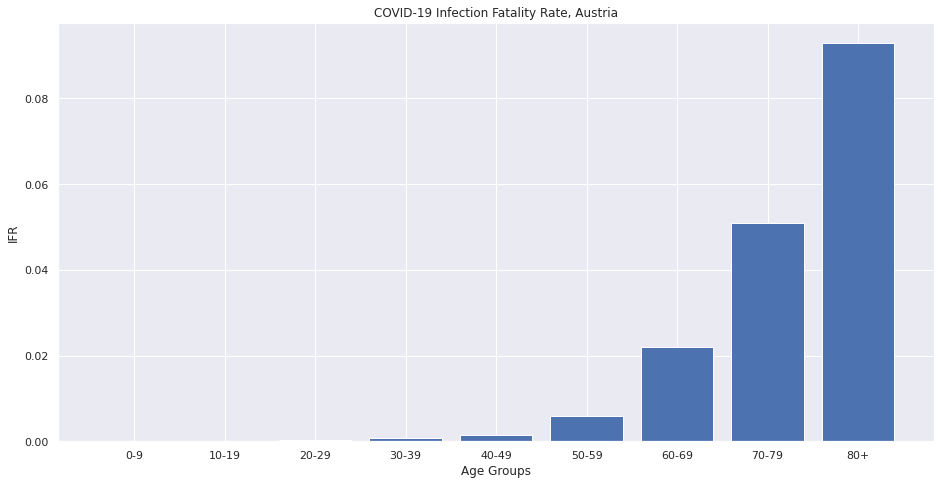

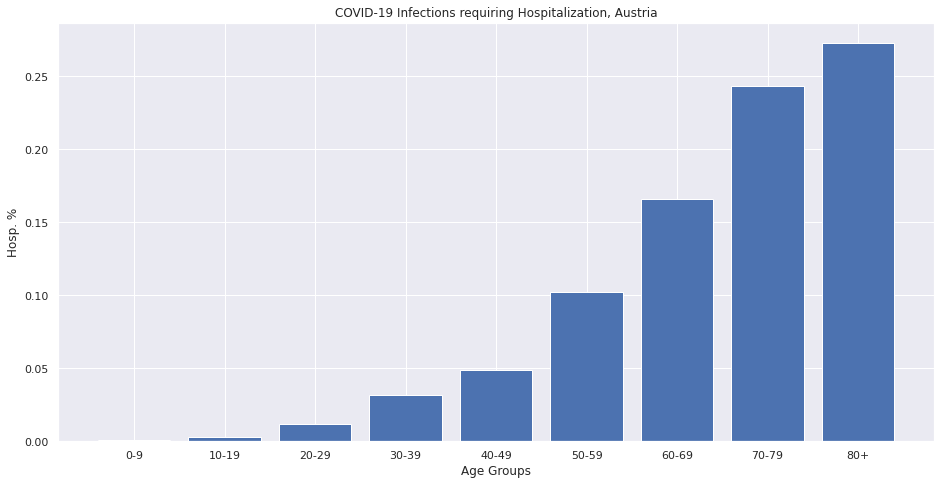

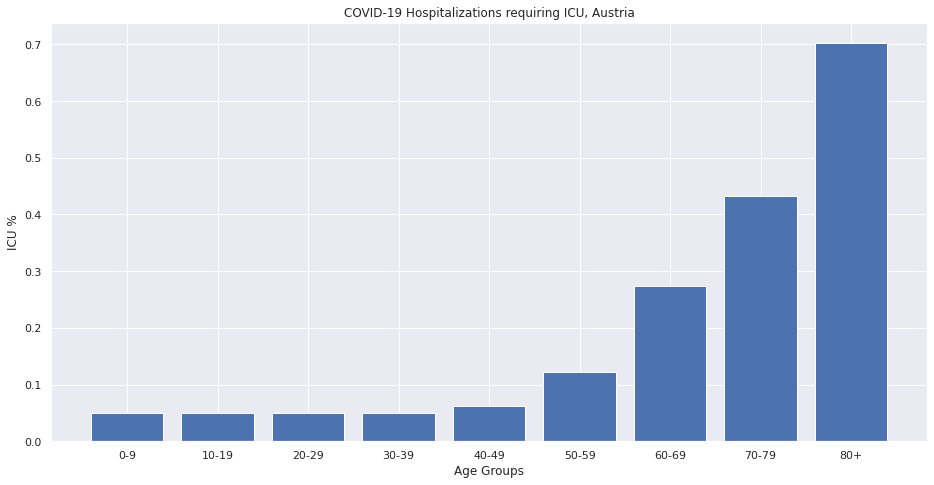

In [4]:
'''
Für die Todesrate von Krankheiten gibt es laut WHO zwei verschiedene wichtige Kennzahlen. 
Mit dem „Fall-Verstorbenen-Anteil” (CFR) wird berechnet, wie viele Todesfälle unter 
allen positiv getesteten Erkrankten zu verzeichnen sind. 
Beim „Infizierten-Verstorbenen-Anteil” (IFR) wird die Zahl der Todesfälle der geschätzten Zahl 
an Gesamtinfizierten gegenübergestellt. Dadurch werden auch Infizierte erfasst, 
die keine oder kaum Symptome aufzeigen und nicht getestet wurden.
'''

# https://corona-ampel.gv.at/sites/corona-ampel.gv.at/files/Kommission_20210311_Sitzungsergebnis.pdf

from zipfile import ZipFile
# Population
# https://www.statistik.at/web_de/statistiken/menschen_und_gesellschaft/bevoelkerung/bevoelkerungsstruktur/bevoelkerung_nach_alter_geschlecht/index.html
dfs = pd.read_excel("./data/bevoelkerung_am_1.1.2020_nach_alter_und_bundesland_-_insgesamt.xlsx", sheet_name=None)
dfs = dfs['Insgesamt'][['Bevölkerung am 1.1.2020 nach Alter und Bundesland - Insgesamt', 'Unnamed: 1']].loc[4:104]
dfs = dfs.reset_index(drop=True)

pop_groups = []
for i in range(0,104,10):
    print('age',i,'to',i+9)
    pop_groups.append(dfs['Unnamed: 1'].loc[i:i+9].sum())

pp80 = sum(pop_groups[-3:])
pop_groups = pop_groups[:-3]
pop_groups.append(pp80)
assert(sum(pop_groups)==dfs['Unnamed: 1'].sum())
print(sum(pop_groups))

#Some Data from birtain -  we will try to obtain hosp rates, icu rates from that data for austria
# Source:
# https://www.imperial.ac.uk/media/imperial-college/medicine/mrc-gida/2020-03-16-COVID19-Report-9.pdf
pop_groups_ifr = [0.00002, 0.00006, 0.0003, 0.0008, 0.0015, 0.006, 0.022, 0.051, 0.093]
pop_groups_hosp = [0.001, 0.003, 0.012, 0.032, 0.049, 0.102, 0.166, 0.243, 0.273]
pop_groups_hosp_icu = [0.05, 0.05, 0.05, 0.05, 0.063, 0.122, 0.274, 0.432, 0.703]

#print(pop_groups)
#print(pop_groups_ifr)
#print(pop_groups_hosp)
#print(pop_groups_hosp_icu)

mod = sm.OLS(pop_groups_hosp, np.array([pop_groups_ifr, pop_groups]).T)
res = mod.fit()
print(res.summary())
#res.predict(np.array([pop_groups_ifr, pop_groups]).T)
        
# Get IFRs, etc for austria
# https://flexikon.doccheck.com/de/Infection_fatality_rate
url = 'https://covid19-dashboard.ages.at/data/data.zip'
save_path = './data/ages/data.zip'

def download_url(url, save_path, chunk_size=128):
    r = requests.get(url, stream=True)
    with open(save_path, 'wb') as fd:
        for chunk in r.iter_content(chunk_size=chunk_size):
            fd.write(chunk)

download_url(url, save_path)
with ZipFile('./data/ages/data.zip', 'r') as zipObj:
    zipObj.extractall(path='./data/ages/')

aut_age_groups = pd.read_csv("./data/ages/CovidFaelle_Altersgruppe.csv", sep=';', index_col = 0, header = 0)

print(aut_age_groups.loc[aut_age_groups['BundeslandID'] <= 9].groupby(['AltersgruppeID']).Altersgruppe.unique())


aut_age_groups = pd.DataFrame(
    [aut_age_groups.loc[aut_age_groups['BundeslandID'] <= 9].groupby(['AltersgruppeID']).Anzahl.sum(),
    aut_age_groups.loc[aut_age_groups['BundeslandID'] <= 9].groupby(['AltersgruppeID']).AnzahlGeheilt.sum(),
    aut_age_groups.loc[aut_age_groups['BundeslandID'] <= 9].groupby(['AltersgruppeID']).AnzahlTot.sum(),
    aut_age_groups.loc[aut_age_groups['BundeslandID'] <= 9].groupby(['AltersgruppeID']).AnzEinwohner.sum(),
    aut_age_groups.loc[aut_age_groups['BundeslandID'] <= 9].groupby(['AltersgruppeID']).Altersgruppe.unique()
    ]
).T#.reset_index(drop=True)

aut_age_groups['CFR'] = aut_age_groups.AnzahlTot/aut_age_groups.Anzahl
aut_age_groups['IFR'] = aut_age_groups['CFR']*(1-0.34)
aut_age_groups['Hosp'] = np.clip(
    res.predict(np.array([aut_age_groups['IFR'], aut_age_groups['AnzEinwohner']]).T),
    0.0,1.0)
print(aut_age_groups)

aut_hosp_groups = pd.read_csv("./data/ages/CovidFallzahlen.csv", sep=';', index_col = 0, header = 0,
                dtype  = {'Datum' : str, 'R_eff': str, 'R_eff_lwr' : str, 'R_eff_upr' : str} )

print(aut_hosp_groups.head(15))

aut_hosp_groups = pd.DataFrame(
    [aut_hosp_groups.loc[aut_hosp_groups['BundeslandID'] <= 9].groupby('Meldedat').FZHosp.sum(),
     aut_hosp_groups.loc[aut_hosp_groups['BundeslandID'] <= 9].groupby('Meldedat').FZHospFree.sum(),
     aut_hosp_groups.loc[aut_hosp_groups['BundeslandID'] <= 9].groupby('Meldedat').FZICU.sum(),
     aut_hosp_groups.loc[aut_hosp_groups['BundeslandID'] <= 9].groupby('Meldedat').FZICUFree.sum(),
    ]
).T

#plt.plot([9, 66])
#print(aut_hosp_groups['FZHosp'], aut_age_groups)




mod = sm.OLS(pop_groups_hosp_icu, np.array([pop_groups_hosp, pop_groups_ifr, pop_groups]).T)
res = mod.fit()
print(res.summary())
aut_age_groups['Hosp_ICU'] = np.clip(res.predict(np.array([
                                aut_age_groups['Hosp'],
                                aut_age_groups['IFR'], 
                                aut_age_groups['AnzEinwohner']]).T), 0.0, 1.0)
    

x = np.linspace(0, len(aut_age_groups['IFR']), len(aut_age_groups['IFR']), endpoint=False, dtype=int)

plt.xlabel('Age Groups')
plt.ylabel('Millions')
plt.title('Population, Austria')
plt.bar(x, aut_age_groups['AnzEinwohner'], tick_label=aut_age_groups['Altersgruppe'])
plt.show()


plt.xlabel('Age Groups')
plt.ylabel('Hospitalization Rate')
plt.title('COVID-19 Hospitalization Rate, Austria')
plt.bar(x, aut_age_groups['Hosp'], 
        tick_label=aut_age_groups['Altersgruppe'])
plt.show()

x = np.linspace(0, len(aut_age_groups['IFR']), len(aut_age_groups['IFR']), endpoint=False, dtype=int)
plt.xlabel('Age Groups')
plt.ylabel('IFR')
plt.title('COVID-19 IFR, Austria')
plt.bar(x, aut_age_groups['IFR'], tick_label=aut_age_groups['Altersgruppe'])
plt.show()

x = np.linspace(0, len(aut_age_groups['IFR']), len(aut_age_groups['IFR']), endpoint=False, dtype=int)
plt.xlabel('Age Groups')
plt.ylabel('Hos. ICU')
plt.title('COVID-19 Hospitalization ICU Rate, Austria')
plt.bar(x, aut_age_groups['Hosp_ICU'], tick_label=aut_age_groups['Altersgruppe'])
plt.show()



x = np.linspace(0, len(pop_groups), len(pop_groups), endpoint=False, dtype=int)
groups_labels = ["{}-{}".format(i, i+9) for i in range(0,90,10)][:-1]+['80+']
plt.xlabel('Age Groups')
plt.ylabel('Millions')
plt.title('Population, Austria')
plt.bar(x, pop_groups, tick_label=groups_labels)
plt.show()

plt.xlabel('Age Groups')
plt.ylabel('IFR')
plt.title('COVID-19 Infection Fatality Rate, Austria')
plt.bar(x, pop_groups_ifr, tick_label=groups_labels)
plt.show()

plt.xlabel('Age Groups')
plt.ylabel('Hosp. %')
plt.title('COVID-19 Infections requiring Hospitalization, Austria')
plt.bar(x, pop_groups_hosp, tick_label=groups_labels)
plt.show()

plt.xlabel('Age Groups')
plt.ylabel('ICU %')
plt.title('COVID-19 Hospitalizations requiring ICU, Austria')
plt.bar(x, pop_groups_hosp_icu, tick_label=groups_labels)
plt.show()

        
pop_groups_hosp_icu = aut_age_groups['Hosp_ICU'].to_numpy()
pop_groups_hosp = aut_age_groups['Hosp'].to_numpy()
pop_groups_ifr = aut_age_groups['IFR'].to_numpy()
pop_groups = aut_age_groups['AnzEinwohner'].to_numpy()


         Date  Vaccinations  Vaccinated_once  Vaccinated_full
0  2020-12-27           737              737                0
1  2020-12-28          2044             2044                0
2  2020-12-29          3669             3669                0
3  2020-12-30          5029             5029                0
4  2020-12-31          5039             5039                0
5  2021-01-01          5046             5046                0
6  2021-01-02          5053             5053                0
7  2021-01-03          5058             5058                0
8  2021-01-04          5179             5179                0
9  2021-01-05          6985             6985                0
10 2021-01-06          7832             7832                0
11 2021-01-07         11102            11102                0
12 2021-01-08         24173            24173                0
13 2021-01-09         28633            28633                0
14 2021-01-10         30874            30874                0
15 2021-

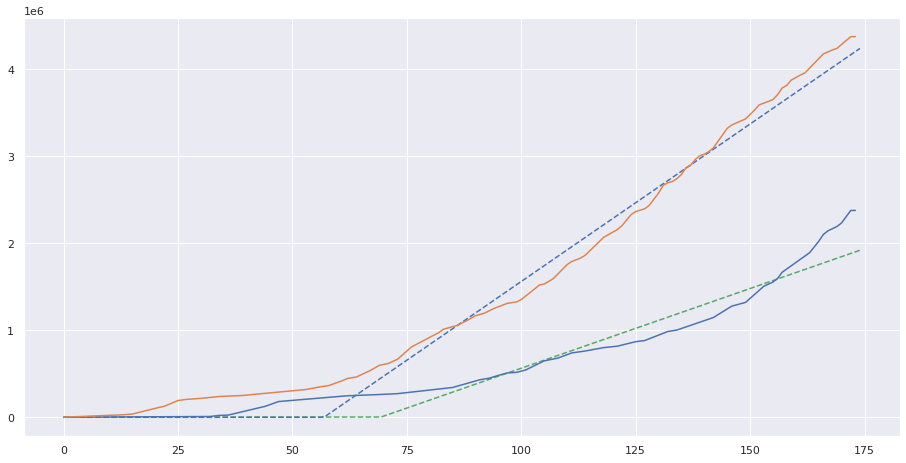

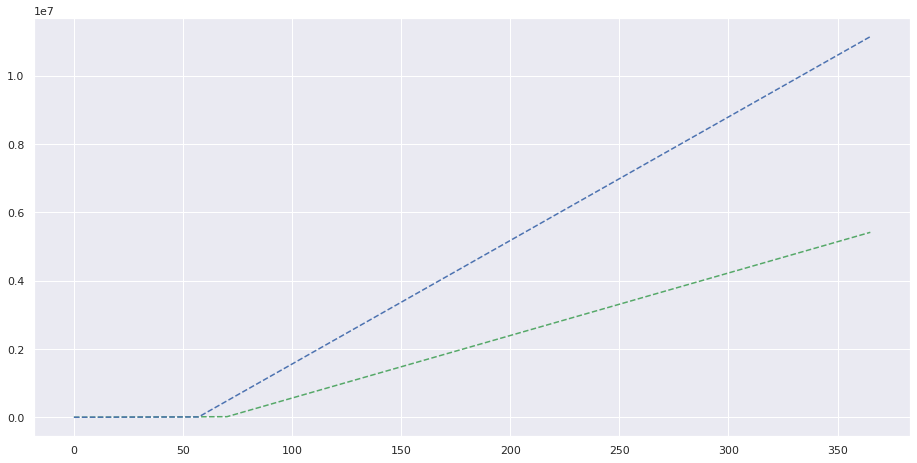

36277.97732389346 18362.27832401544


In [5]:
# Vaccines
print(aut_vac.head(25))
vac_full_data = aut_vac['Vaccinated_full'].to_numpy()
vac_once_data = aut_vac['Vaccinated_once'].to_numpy()
# plt.plot(aut_vac['Vaccinated_full'].to_numpy())

# Start Date is 2020-12-27 for vaccinated once, 
# 2021-01-15 for vaccinated
# 307 days and XXX days after start of pandemic in Austria on 25.02.2020

# Next we fit a 4th degree polynomial to the vaccinations curve using least squares method
# so we can estimate future vaccinations progress.

#poly4 = lambda x, a, b, c, d, e: a*(x**4) + b*(x**3) + c*(x**2) + d*(x**2) + e
#def func(x, a, b, c, d, e):
#    y = poly4(x, a, b, c, d, e)
#    return np.abs(y*(y>0))
    
#poly3 = lambda x, a, b, c, d: a*(x**3) + b*(x**2) + c*(x**1) + d*(x**0) 
#def func(x, a, b, c, d):
#    y = poly3(x, a, b, c, d)
#    return np.abs(y*(y>0))

#poly2 = lambda x, a, b, c: a*(x**2) + b*(x**1) + c*(x**0)
#def func(x, a, b, c):
#    y = poly2(x, a, b, c)
#    return np.abs(y*(y>0))

poly1 = lambda x, a, b: a*(x**1) + b*(x**0)
def vac_full(x, a, b):
    y = poly1(x, a, b)
    return np.abs(y*(y>0))

poly1 = lambda x, a, b: a*(x**1) + b*(x**0)
def vac_once(x, a, b):
    y = poly1(x, a, b)
    return np.abs(y*(y>0))
    
    

xdata = np.linspace(0,1,len(vac_full_data))*len(vac_full_data)
popt_full, pcov_full = curve_fit(vac_full, xdata, vac_full_data, method='lm')

xdata = np.linspace(0,1,len(vac_once_data))*len(vac_once_data)
popt_once, pcov_once = curve_fit(vac_once, xdata, vac_once_data, method='lm')

# Check quality of fit with R2
print(r2_score(vac_full(xdata, *popt_full), vac_full_data))
plt.plot(xdata, vac_full(xdata, *popt_full), 'g--')
plt.plot(xdata, vac_once(xdata, *popt_once), 'b--')
plt.plot(vac_full_data)
plt.plot(vac_once_data)
plt.show()

# Predict a whole year of vaccinations and see how it looks like:
dur = 365
xdata = np.linspace(0,1,dur)*dur
plt.plot(xdata, vac_full(xdata, *popt_full), 'g--')
plt.plot(xdata, vac_once(xdata, *popt_once), 'b--')
plt.show()

vac_full_curve = vac_full(xdata, *popt_full)
vac_full_per_day = vac_full_curve[-1]-vac_full_curve[-2]

vac_once_curve = vac_once(xdata, *popt_once)
vac_once_per_day = vac_once_curve[-1]-vac_once_curve[-2]
print(vac_once_per_day, vac_full_per_day)

               R_eff  R_eff_lwr  R_eff_upr
Datum                                     
2020-03-10  2.184247   1.895462   2.493209
2020-03-11  2.566776   2.289402   2.859781
2020-03-12  2.494346   2.257588   2.742740
2020-03-13  2.631449   2.422677   2.848726
2020-03-14  2.574769   2.398659   2.757029


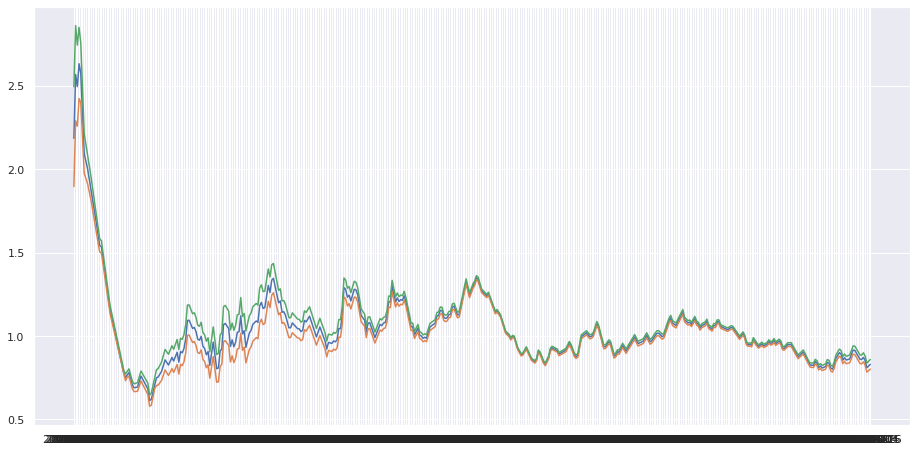

In [6]:
# Effective reproduction number, etc AGES
# https://www.ages.at/en/wissen-aktuell/publikationen/epidemiologische-parameter-des-covid19-ausbruchs-oesterreich-20202021/

urls = ['https://www.ages.at/fileadmin/AGES2015/Wissen-Aktuell/COVID19/growth.csv',
     'https://www.ages.at/fileadmin/AGES2015/Wissen-Aktuell/COVID19/R_eff.csv',
     'https://www.ages.at/fileadmin/AGES2015/Wissen-Aktuell/COVID19/R_eff_bundesland.csv',
     'https://www.ages.at/fileadmin/AGES2015/Wissen-Aktuell/COVID19/meta_data.csv'
    ]

for url in urls:
    with open('./data/ages/'+os.path.split(url)[1], 'wb') as f, \
            requests.get(url, stream=True) as r:
        for line in r.iter_lines():
            f.write(line+'\n'.encode())

aut_reff = pd.read_csv("./data/ages/R_eff.csv", sep=';', index_col = 0, header = 0,
                dtype  = {'Datum' : str, 'R_eff': str, 'R_eff_lwr' : str, 'R_eff_upr' : str} ) 
aut_reff[0:]=aut_reff[0:].replace({',' : '.'}, regex=True).astype(float)
print(aut_reff.head())

plt.plot(aut_reff['R_eff'], label='R_eff')
plt.plot(aut_reff['R_eff_lwr'], label='R_eff_lwr')
plt.plot(aut_reff['R_eff_upr'], label='R_eff_upr')
plt.show()

Int64Index([202003, 202004, 202005, 202006, 202007, 202008, 202009, 202010,
            202011, 202012, 202101, 202102, 202103, 202104, 202105],
           dtype='int64', name='REF_DATE')
Index(['NUTS1', 'NUTS2', 'NUTS3', 'DISTRICT_CODE', 'SUB_DISTRICT_CODE', 'T',
       'T_MAX', 'T_MIN', 'MEAN_T_MAX', 'MEAN_T_MIN', 'NUM_FROST', 'NUM_ICE',
       'NUM_SUMMER', 'NUM_HEAT', 'P', 'P_MAX', 'P_MIN', 'SUN_H', 'NUM_CLEAR',
       'NUM_CLOUD', 'REL_HUM', 'REL_HUM_MAX', 'REL_HUM_MIN', 'WIND_VEL',
       'NUM_WIND_VEL60', 'WIND_VEL_MAX', 'PRECP_SUM', 'NUM_PRECP_01',
       'STAT_NUM', 'Unnamed: 30', 'Unnamed: 31'],
      dtype='object')


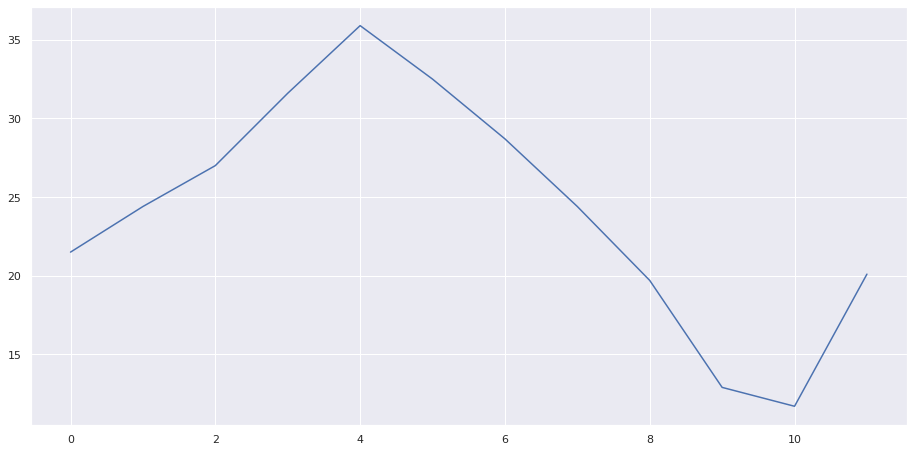

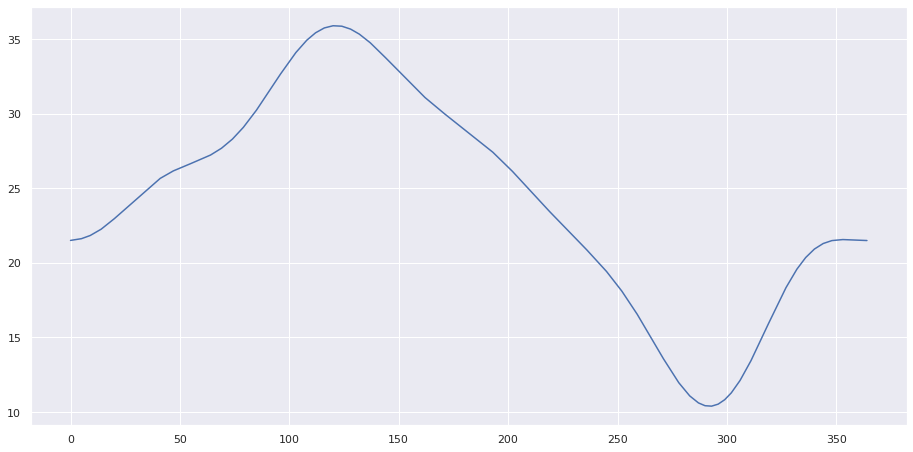

In [7]:
# Some papers suggest association between temperatures and virus spread
# https://repositum.tuwien.at/bitstream/20.500.12708/17056/1/Prager%20Lukas%20-%202021%20-%20Examining%20Austrian%20COVID-19%20Data%20in%20the%20Context%20of%20Linear...pdf#%5B%7B%22num%22%3A1106%2C%22gen%22%3A0%7D%2C%7B%22name%22%3A%22XYZ%22%7D%2C72%2C628.0339966%2Cnull%5D
# https://www.sciencedirect.com/science/article/pii/S0048969720379213
# https://www.sciencedirect.com/science/article/pii/S1201971220302848

url = 'https://www.wien.gv.at/gogv/l9ogdwetter'
with open('./data/wiengv/'+os.path.split(url)[1], 'wb') as f, \
            requests.get(url, stream=True) as r:
        for line in r.iter_lines():
            f.write(line+'\n'.encode())
            
aut_weather= pd.read_csv("./data/wiengv/l9ogdwetter", sep=';', index_col = 0, header = 1)
aut_weather[aut_weather.columns[5:29]] = aut_weather[aut_weather.columns[5:29]].replace({',' : '.'}, regex=True).astype(float)
print(aut_weather.index[782:]) #which rows to select for data since march 1 2020
print(aut_weather.columns)
X_w = aut_weather[aut_weather.columns[6]].iloc[782:782+12].to_numpy()
plt.plot(X_w)
plt.show()
X_w = signal.resample(X_w, aut_reff['R_eff'].iloc[0:365].to_numpy().shape[0])
plt.plot(X_w)
plt.show()

#avg over last 3 yrs
#X_w += signal.resample(aut_weather[aut_weather.columns[6]].iloc[782-12:782-12+11].to_numpy(), 
#                      aut_reff['R_eff'].iloc[0:365].to_numpy().shape[0])

#X_w += signal.resample(aut_weather[aut_weather.columns[6]].iloc[782-24:782-24+11].to_numpy(), 
#                      aut_reff['R_eff'].iloc[0:365].to_numpy().shape[0])

#X_w= X_w/3

#plt.plot(X_w)
#plt.show()

## Regression analysis of variables

In [8]:
# Remove Colinear Variables
# https://stats.stackexchange.com/questions/155028/how-to-systematically-remove-collinear-variables-pandas-columns-in-python
# https://www.statsmodels.org/stable/generated/statsmodels.stats.outliers_influence.variance_inflation_factor.html   

def calculate_vif_(X, thresh=5.0):
    variables = list(range(X.shape[1]))
    dropped = True
    while dropped:
        dropped = False
        vif = []
        for ix in range(X.iloc[:, variables].shape[1]):
            try:
                vif_ix = variance_inflation_factor(X.iloc[:, variables].values, ix)
                vif.append(vif_ix)
            except:
                vif.append(thresh+1.0)

        maxloc = vif.index(max(vif))
        if max(vif) > thresh:
            print('dropping \'' + X.iloc[:, variables].columns[maxloc] +
                  '\' at index: ' + str(maxloc))
            del variables[maxloc]
            dropped = True

    print('Remaining variables:')
    print(X.columns[variables])
    return X.iloc[:, variables]

In [9]:
# Regression analysis
# Goodness of fit --> R2
# Significance F-Test overall, t-tests individual params.
# Evaluate OLS model on all features via F/t-testing
# Interpretation:
# https://medium.com/@jyotiyadav99111/statistics-how-should-i-interpret-results-of-ols-3bde1ebeec01
# https://medium.com/analytics-vidhya/how-to-interpret-result-from-linear-regression-3f7ae7679ef9
# https://de.wikipedia.org/wiki/Testen_allgemeiner_linearer_Hypothesen#Einzelgleichungsmodell
# https://statisticsbyjim.com/regression/interpret-coefficients-p-values-regression/
# https://en.wikipedia.org/wiki/Regression_analysis

# Effective reproduction number
y = aut_reff['R_eff'].iloc[0:365].to_numpy()
y_lwr = aut_reff['R_eff_lwr'].iloc[0:365].to_numpy()
y_upr = aut_reff['R_eff_upr'].iloc[0:365].to_numpy()

# Pandemic
X_p = pd.DataFrame(aut_cov['Infected'].iloc[0:365], columns=['Infected'])
X_p = pd.concat((X_p, pd.DataFrame(aut_cov['Fatal'].iloc[0:365], columns=['Fatal'])), axis=1)
X_p = pd.concat((X_p, pd.DataFrame(aut_cov['Recovered'].iloc[0:365], columns=['Recovered'])), axis=1)
X_p = pd.concat((X_p, pd.DataFrame(aut_cov['Confirmed'].iloc[0:365], columns=['Confirmed'])), axis=1)

# Gov. measures from oxford tracker
X_g = aut_gov[69:(69+365)][aut_gov.columns[1:]].reset_index(drop=True) #10 march
      
# Weather data from Hohe Warte (ZAMG unfortunately has a paywall...)
X_w = aut_weather.iloc[782:][aut_weather.columns[5:28]]
X_w = signal.resample(X_w, y.shape[0])
X_w = pd.DataFrame(X_w, columns = aut_weather.columns[5:28])
X_w_c = calculate_vif_(X_w) # Remove multicolinear columns from weather data 

# Merge datasets analyse them togather
X_wgp = pd.concat((X_w, X_g, X_p), axis=1)
X_wg = pd.concat((X_w, X_g), axis=1)
X_gp = pd.concat((X_g, X_p), axis=1)
X_wp = pd.concat((X_w, X_p), axis=1)

X_w_cgp = pd.concat((X_w_c, X_g, X_p), axis=1)
X_w_cg = pd.concat((X_w_c, X_g), axis=1)
X_w_cp = pd.concat((X_w_c, X_p), axis=1)

dropping 'T' at index: 0
dropping 'T_MAX' at index: 0
dropping 'T_MIN' at index: 0
dropping 'MEAN_T_MAX' at index: 0
dropping 'MEAN_T_MIN' at index: 0
dropping 'NUM_FROST' at index: 0
dropping 'NUM_ICE' at index: 0
dropping 'NUM_SUMMER' at index: 0
dropping 'P_MAX' at index: 2
dropping 'P_MIN' at index: 2
dropping 'REL_HUM_MAX' at index: 6
dropping 'WIND_VEL' at index: 7
dropping 'REL_HUM' at index: 5
dropping 'NUM_PRECP_01' at index: 9
dropping 'WIND_VEL_MAX' at index: 7
dropping 'NUM_CLOUD' at index: 4
dropping 'SUN_H' at index: 2
dropping 'PRECP_SUM' at index: 5
dropping 'REL_HUM_MIN' at index: 3
Remaining variables:
Index(['NUM_HEAT', 'P', 'NUM_CLEAR', 'NUM_WIND_VEL60'], dtype='object')


X_w, R_lwr
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.732
Model:                            OLS   Adj. R-squared:                  0.721
Method:                 Least Squares   F-statistic:                     68.27
Date:                Fri, 18 Jun 2021   Prob (F-statistic):           6.07e-91
Time:                        20:13:13   Log-Likelihood:                 226.55
No. Observations:                 365   AIC:                            -423.1
Df Residuals:                     350   BIC:                            -364.6
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
T                 -0.0108      0.

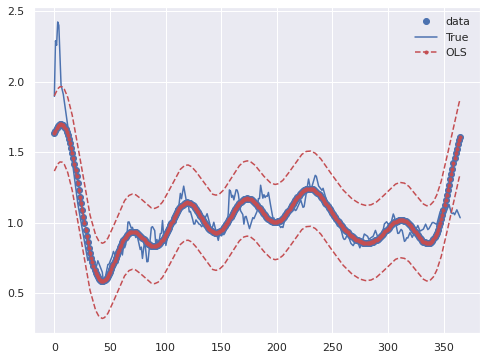

X_w, R
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.696
Model:                            OLS   Adj. R-squared:                  0.684
Method:                 Least Squares   F-statistic:                     57.29
Date:                Fri, 18 Jun 2021   Prob (F-statistic):           1.48e-81
Time:                        20:13:13   Log-Likelihood:                 179.04
No. Observations:                 365   AIC:                            -328.1
Df Residuals:                     350   BIC:                            -269.6
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
T                 -0.0071      0.005 

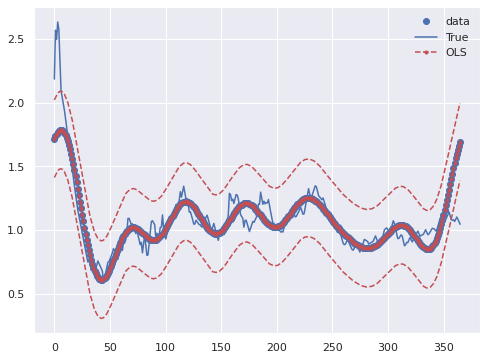

X_w, R_upr
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.666
Model:                            OLS   Adj. R-squared:                  0.653
Method:                 Least Squares   F-statistic:                     49.95
Date:                Fri, 18 Jun 2021   Prob (F-statistic):           1.44e-74
Time:                        20:13:13   Log-Likelihood:                 132.53
No. Observations:                 365   AIC:                            -235.1
Df Residuals:                     350   BIC:                            -176.6
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
T                 -0.0033      0.

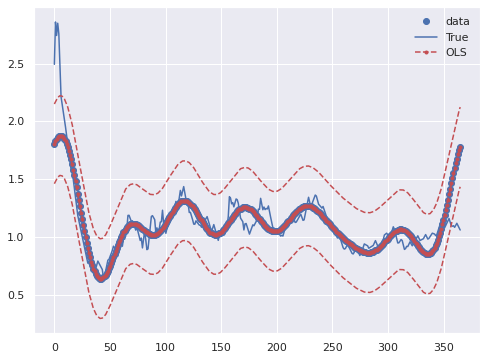

X_p, R_lwr
                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.734
Model:                            OLS   Adj. R-squared (uncentered):              0.732
Method:                 Least Squares   F-statistic:                              333.0
Date:                Fri, 18 Jun 2021   Prob (F-statistic):                   1.02e-103
Time:                        20:13:13   Log-Likelihood:                         -298.01
No. Observations:                 365   AIC:                                      602.0
Df Residuals:                     362   BIC:                                      613.7
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------

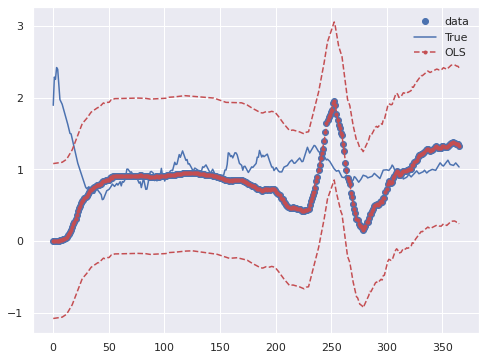

X_p, R
                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.729
Model:                            OLS   Adj. R-squared (uncentered):              0.726
Method:                 Least Squares   F-statistic:                              324.0
Date:                Fri, 18 Jun 2021   Prob (F-statistic):                   3.88e-102
Time:                        20:13:14   Log-Likelihood:                         -316.16
No. Observations:                 365   AIC:                                      638.3
Df Residuals:                     362   BIC:                                      650.0
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------

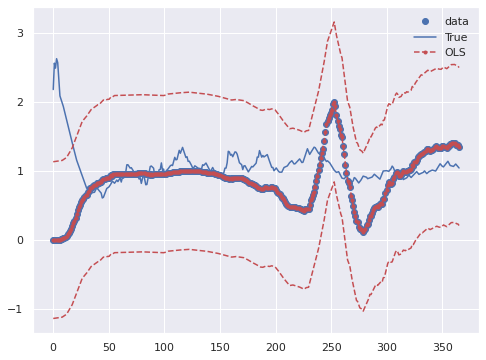

X_p, R_upr
                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.723
Model:                            OLS   Adj. R-squared (uncentered):              0.720
Method:                 Least Squares   F-statistic:                              314.5
Date:                Fri, 18 Jun 2021   Prob (F-statistic):                   1.91e-100
Time:                        20:13:14   Log-Likelihood:                         -334.82
No. Observations:                 365   AIC:                                      675.6
Df Residuals:                     362   BIC:                                      687.3
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------

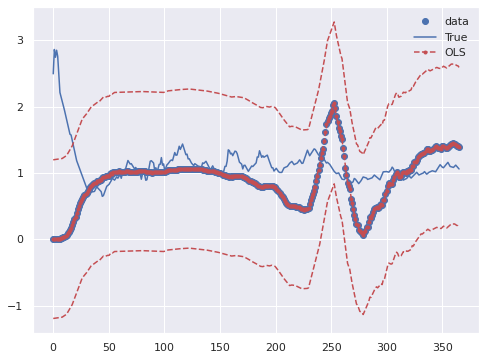

X_g, R_lwr
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.665
Model:                            OLS   Adj. R-squared:                  0.657
Method:                 Least Squares   F-statistic:                     88.32
Date:                Fri, 18 Jun 2021   Prob (F-statistic):           8.43e-80
Time:                        20:13:14   Log-Likelihood:                 185.84
No. Observations:                 365   AIC:                            -353.7
Df Residuals:                     356   BIC:                            -318.6
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------

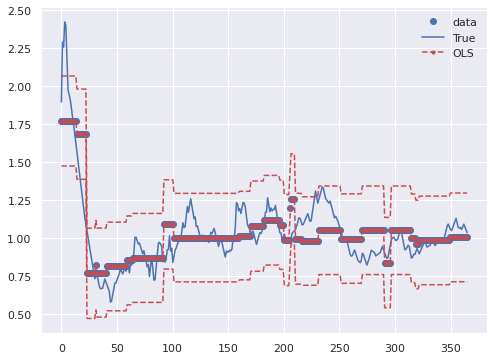

X_g, R
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.656
Model:                            OLS   Adj. R-squared:                  0.648
Method:                 Least Squares   F-statistic:                     84.84
Date:                Fri, 18 Jun 2021   Prob (F-statistic):           9.18e-78
Time:                        20:13:14   Log-Likelihood:                 156.34
No. Observations:                 365   AIC:                            -294.7
Df Residuals:                     356   BIC:                            -259.6
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------

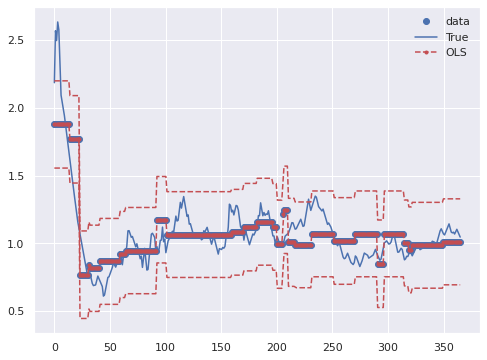

X_g, R_upr
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.647
Model:                            OLS   Adj. R-squared:                  0.639
Method:                 Least Squares   F-statistic:                     81.70
Date:                Fri, 18 Jun 2021   Prob (F-statistic):           6.99e-76
Time:                        20:13:14   Log-Likelihood:                 122.39
No. Observations:                 365   AIC:                            -226.8
Df Residuals:                     356   BIC:                            -191.7
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------

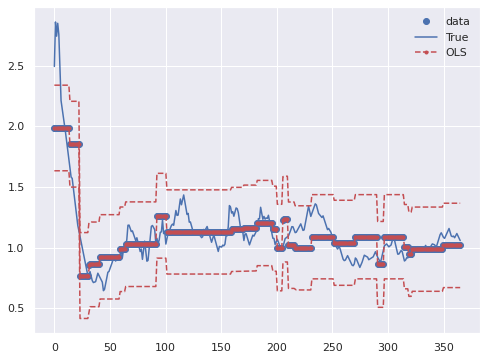

X_w_c, R_lwr
                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.920
Model:                            OLS   Adj. R-squared (uncentered):              0.919
Method:                 Least Squares   F-statistic:                              1041.
Date:                Fri, 18 Jun 2021   Prob (F-statistic):                   9.60e-197
Time:                        20:13:14   Log-Likelihood:                         -78.186
No. Observations:                 365   AIC:                                      164.4
Df Residuals:                     361   BIC:                                      180.0
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                     coef    std err          t      P>|t|      [0.025      0.975]
------------------------

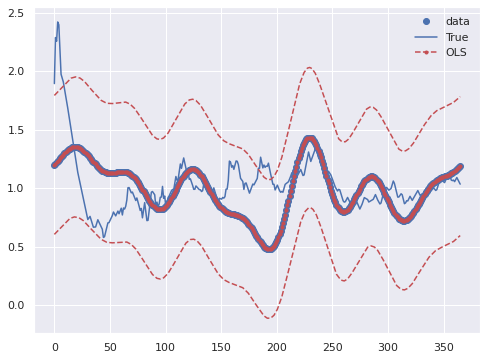

X_w_c, R
                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.918
Model:                            OLS   Adj. R-squared (uncentered):              0.917
Method:                 Least Squares   F-statistic:                              1011.
Date:                Fri, 18 Jun 2021   Prob (F-statistic):                   1.29e-194
Time:                        20:13:15   Log-Likelihood:                         -97.622
No. Observations:                 365   AIC:                                      203.2
Df Residuals:                     361   BIC:                                      218.8
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------

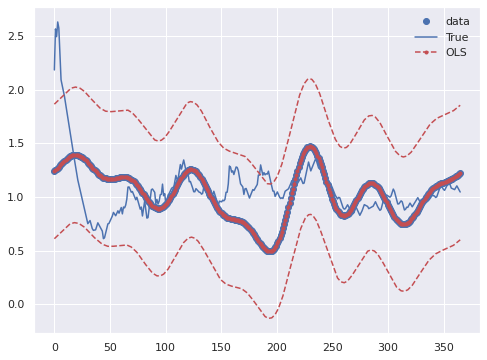

X_w_c, R_upr
                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.915
Model:                            OLS   Adj. R-squared (uncentered):              0.914
Method:                 Least Squares   F-statistic:                              968.6
Date:                Fri, 18 Jun 2021   Prob (F-statistic):                   1.57e-191
Time:                        20:13:15   Log-Likelihood:                         -119.53
No. Observations:                 365   AIC:                                      247.1
Df Residuals:                     361   BIC:                                      262.7
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                     coef    std err          t      P>|t|      [0.025      0.975]
------------------------

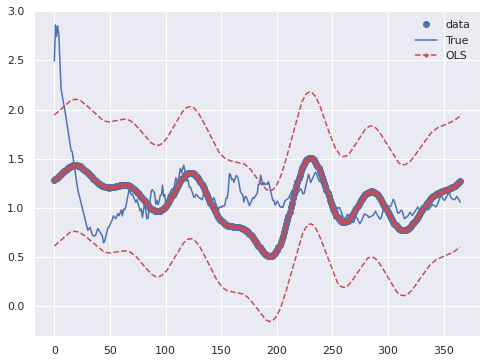

X_wgp, R_lwr
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.951
Model:                            OLS   Adj. R-squared:                  0.947
Method:                 Least Squares   F-statistic:                     260.6
Date:                Fri, 18 Jun 2021   Prob (F-statistic):          1.30e-204
Time:                        20:13:15   Log-Likelihood:                 534.95
No. Observations:                 365   AIC:                            -1018.
Df Residuals:                     339   BIC:                            -916.5
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------

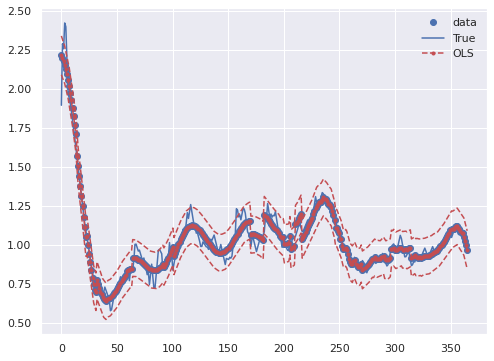

X_wgp, R
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.951
Model:                            OLS   Adj. R-squared:                  0.948
Method:                 Least Squares   F-statistic:                     264.9
Date:                Fri, 18 Jun 2021   Prob (F-statistic):          9.24e-206
Time:                        20:13:15   Log-Likelihood:                 513.15
No. Observations:                 365   AIC:                            -974.3
Df Residuals:                     339   BIC:                            -872.9
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------

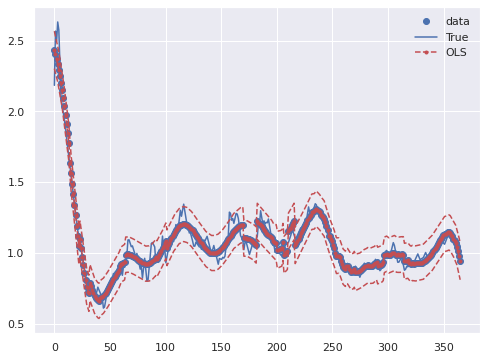

X_wgp, R_upr
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.951
Model:                            OLS   Adj. R-squared:                  0.947
Method:                 Least Squares   F-statistic:                     263.6
Date:                Fri, 18 Jun 2021   Prob (F-statistic):          1.96e-205
Time:                        20:13:15   Log-Likelihood:                 482.88
No. Observations:                 365   AIC:                            -913.8
Df Residuals:                     339   BIC:                            -812.4
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------

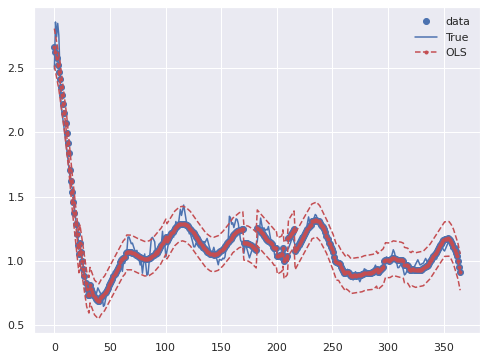

X_wg, R_lwr
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.913
Model:                            OLS   Adj. R-squared:                  0.908
Method:                 Least Squares   F-statistic:                     163.4
Date:                Fri, 18 Jun 2021   Prob (F-statistic):          1.21e-166
Time:                        20:13:16   Log-Likelihood:                 432.13
No. Observations:                 365   AIC:                            -818.3
Df Residuals:                     342   BIC:                            -728.6
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------

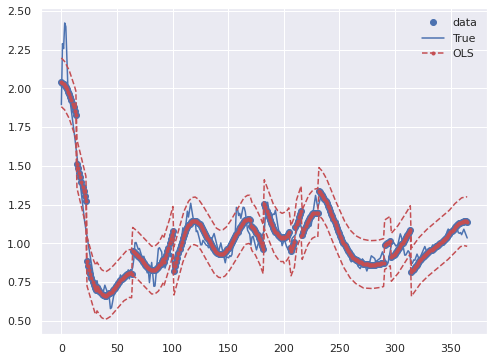

X_wg, R
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.902
Model:                            OLS   Adj. R-squared:                  0.896
Method:                 Least Squares   F-statistic:                     143.1
Date:                Fri, 18 Jun 2021   Prob (F-statistic):          8.81e-158
Time:                        20:13:16   Log-Likelihood:                 385.57
No. Observations:                 365   AIC:                            -725.1
Df Residuals:                     342   BIC:                            -635.4
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------

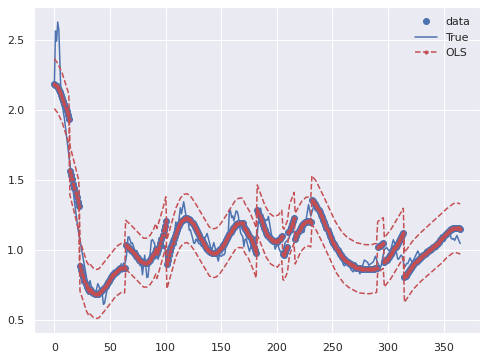

X_wg, R_upr
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.890
Model:                            OLS   Adj. R-squared:                  0.883
Method:                 Least Squares   F-statistic:                     126.1
Date:                Fri, 18 Jun 2021   Prob (F-statistic):          1.95e-149
Time:                        20:13:16   Log-Likelihood:                 335.46
No. Observations:                 365   AIC:                            -624.9
Df Residuals:                     342   BIC:                            -535.2
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------

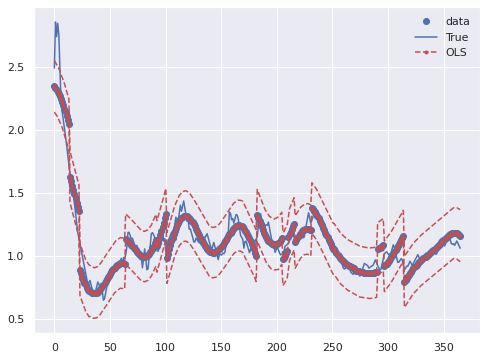

X_gp, R_lwr
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.700
Model:                            OLS   Adj. R-squared:                  0.690
Method:                 Least Squares   F-statistic:                     74.79
Date:                Fri, 18 Jun 2021   Prob (F-statistic):           3.18e-85
Time:                        20:13:16   Log-Likelihood:                 205.85
No. Observations:                 365   AIC:                            -387.7
Df Residuals:                     353   BIC:                            -340.9
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------

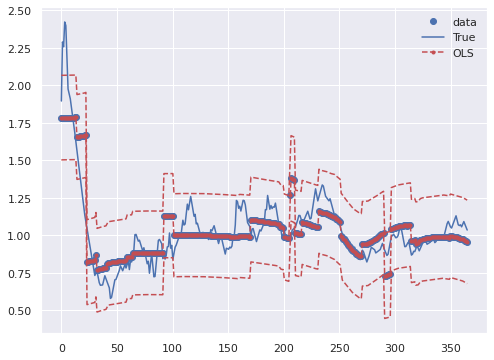

X_gp, R
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.695
Model:                            OLS   Adj. R-squared:                  0.685
Method:                 Least Squares   F-statistic:                     73.08
Date:                Fri, 18 Jun 2021   Prob (F-statistic):           5.33e-84
Time:                        20:13:16   Log-Likelihood:                 178.25
No. Observations:                 365   AIC:                            -332.5
Df Residuals:                     353   BIC:                            -285.7
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------

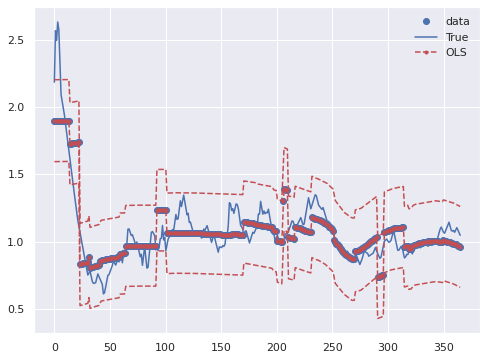

X_gp, R_upr
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.691
Model:                            OLS   Adj. R-squared:                  0.681
Method:                 Least Squares   F-statistic:                     71.63
Date:                Fri, 18 Jun 2021   Prob (F-statistic):           6.02e-83
Time:                        20:13:17   Log-Likelihood:                 146.26
No. Observations:                 365   AIC:                            -268.5
Df Residuals:                     353   BIC:                            -221.7
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------

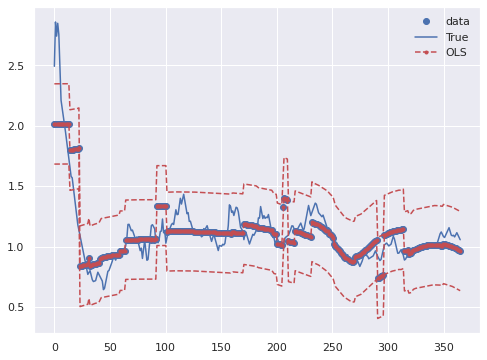

X_wp, R_lwr
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.937
Model:                            OLS   Adj. R-squared:                  0.934
Method:                 Least Squares   F-statistic:                     305.9
Date:                Fri, 18 Jun 2021   Prob (F-statistic):          4.60e-197
Time:                        20:13:17   Log-Likelihood:                 492.13
No. Observations:                 365   AIC:                            -948.3
Df Residuals:                     347   BIC:                            -878.1
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
T                 -0.0772      0

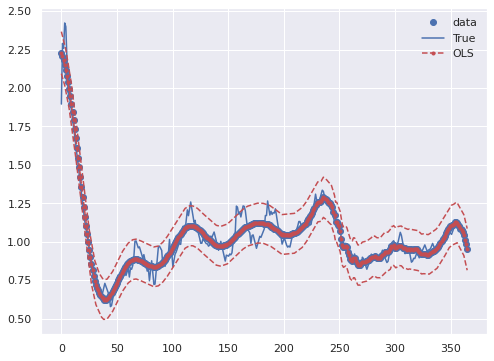

X_wp, R
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.939
Model:                            OLS   Adj. R-squared:                  0.936
Method:                 Least Squares   F-statistic:                     314.7
Date:                Fri, 18 Jun 2021   Prob (F-statistic):          4.54e-199
Time:                        20:13:17   Log-Likelihood:                 472.34
No. Observations:                 365   AIC:                            -908.7
Df Residuals:                     347   BIC:                            -838.5
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
T                 -0.0955      0.007

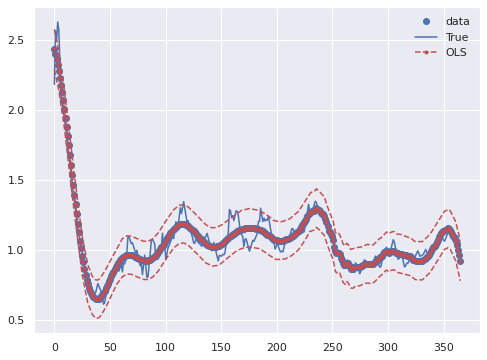

X_wp, R_upr
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.939
Model:                            OLS   Adj. R-squared:                  0.936
Method:                 Least Squares   F-statistic:                     316.7
Date:                Fri, 18 Jun 2021   Prob (F-statistic):          1.69e-199
Time:                        20:13:17   Log-Likelihood:                 443.93
No. Observations:                 365   AIC:                            -851.9
Df Residuals:                     347   BIC:                            -781.7
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
T                 -0.1148      0

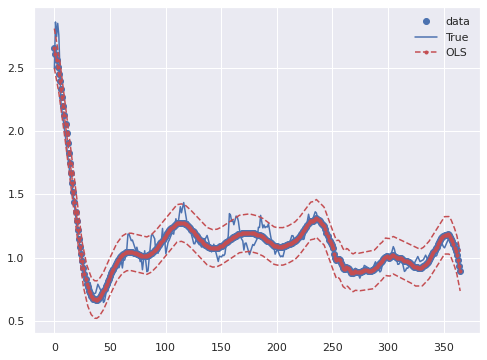

X_w_cgp, R_lwr
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.761
Model:                            OLS   Adj. R-squared:                  0.751
Method:                 Least Squares   F-statistic:                     74.16
Date:                Fri, 18 Jun 2021   Prob (F-statistic):           1.17e-98
Time:                        20:13:17   Log-Likelihood:                 247.63
No. Observations:                 365   AIC:                            -463.3
Df Residuals:                     349   BIC:                            -400.9
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------

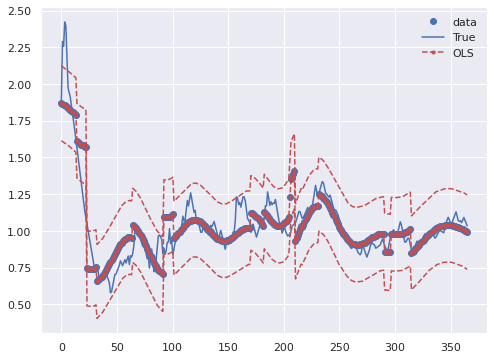

X_w_cgp, R
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.759
Model:                            OLS   Adj. R-squared:                  0.749
Method:                 Least Squares   F-statistic:                     73.33
Date:                Fri, 18 Jun 2021   Prob (F-statistic):           5.08e-98
Time:                        20:13:18   Log-Likelihood:                 221.41
No. Observations:                 365   AIC:                            -410.8
Df Residuals:                     349   BIC:                            -348.4
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------

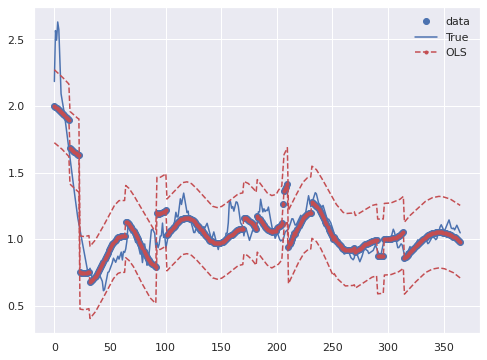

X_w_cgp, R_upr
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.758
Model:                            OLS   Adj. R-squared:                  0.747
Method:                 Least Squares   F-statistic:                     72.71
Date:                Fri, 18 Jun 2021   Prob (F-statistic):           1.53e-97
Time:                        20:13:18   Log-Likelihood:                 190.78
No. Observations:                 365   AIC:                            -349.6
Df Residuals:                     349   BIC:                            -287.2
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------

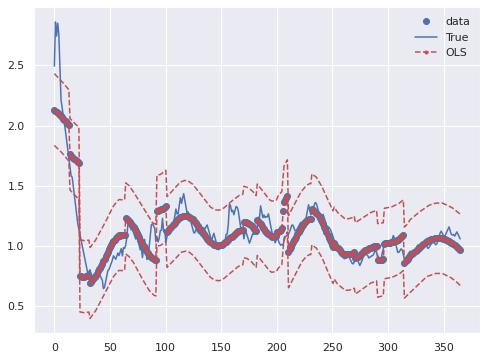

X_w_cg, R_lwr
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.757
Model:                            OLS   Adj. R-squared:                  0.749
Method:                 Least Squares   F-statistic:                     91.50
Date:                Fri, 18 Jun 2021   Prob (F-statistic):          2.39e-100
Time:                        20:13:18   Log-Likelihood:                 244.63
No. Observations:                 365   AIC:                            -463.3
Df Residuals:                     352   BIC:                            -412.6
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------

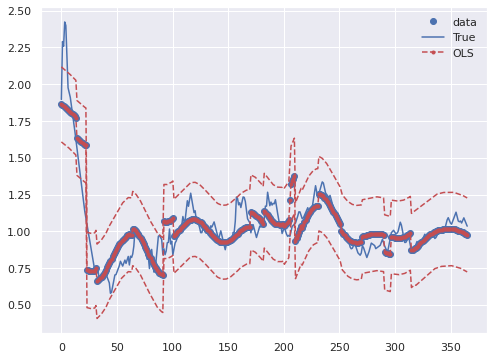

X_w_cg, R
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.752
Model:                            OLS   Adj. R-squared:                  0.744
Method:                 Least Squares   F-statistic:                     89.17
Date:                Fri, 18 Jun 2021   Prob (F-statistic):           7.06e-99
Time:                        20:13:18   Log-Likelihood:                 216.43
No. Observations:                 365   AIC:                            -406.9
Df Residuals:                     352   BIC:                            -356.2
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------

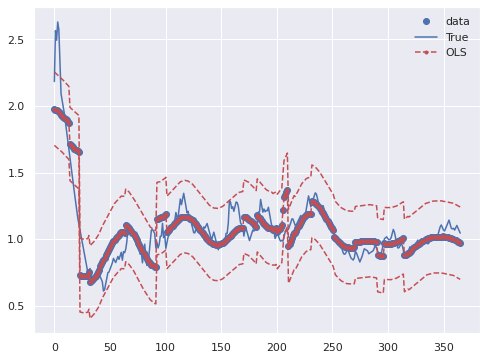

X_w_cg, R_upr
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.748
Model:                            OLS   Adj. R-squared:                  0.739
Method:                 Least Squares   F-statistic:                     86.93
Date:                Fri, 18 Jun 2021   Prob (F-statistic):           1.99e-97
Time:                        20:13:18   Log-Likelihood:                 183.48
No. Observations:                 365   AIC:                            -341.0
Df Residuals:                     352   BIC:                            -290.3
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------

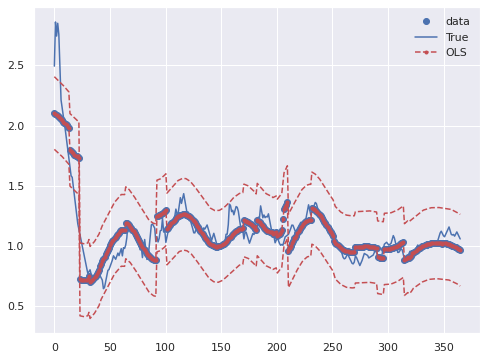

X_w_cp, R_lwr
                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.923
Model:                            OLS   Adj. R-squared (uncentered):              0.921
Method:                 Least Squares   F-statistic:                              610.9
Date:                Fri, 18 Jun 2021   Prob (F-statistic):                   9.29e-195
Time:                        20:13:18   Log-Likelihood:                         -72.380
No. Observations:                 365   AIC:                                      158.8
Df Residuals:                     358   BIC:                                      186.1
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
                     coef    std err          t      P>|t|      [0.025      0.975]
-----------------------

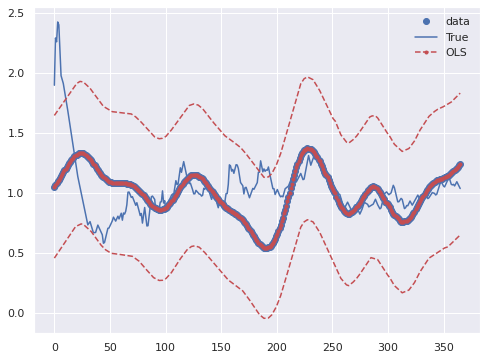

X_w_cp, R
                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.920
Model:                            OLS   Adj. R-squared (uncentered):              0.918
Method:                 Least Squares   F-statistic:                              587.8
Date:                Fri, 18 Jun 2021   Prob (F-statistic):                   5.34e-192
Time:                        20:13:19   Log-Likelihood:                         -93.343
No. Observations:                 365   AIC:                                      200.7
Df Residuals:                     358   BIC:                                      228.0
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
                     coef    std err          t      P>|t|      [0.025      0.975]
---------------------------

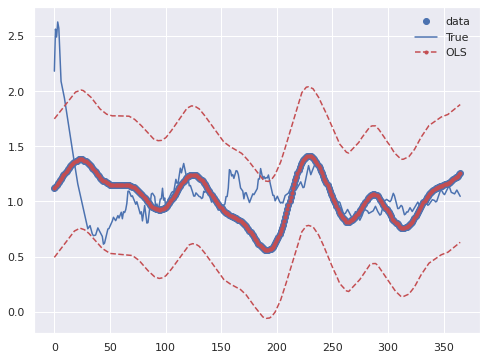

X_w_cp, R_upr
                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.917
Model:                            OLS   Adj. R-squared (uncentered):              0.915
Method:                 Least Squares   F-statistic:                              562.3
Date:                Fri, 18 Jun 2021   Prob (F-statistic):                   7.70e-189
Time:                        20:13:19   Log-Likelihood:                         -115.49
No. Observations:                 365   AIC:                                      245.0
Df Residuals:                     358   BIC:                                      272.3
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
                     coef    std err          t      P>|t|      [0.025      0.975]
-----------------------

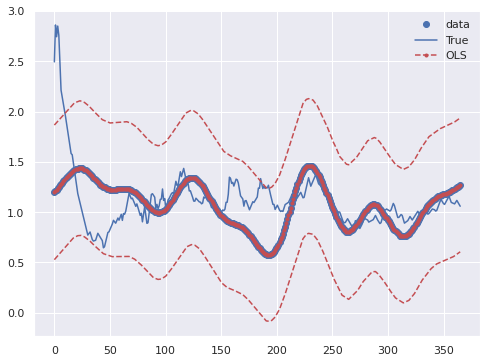

X_w, Fatal
                            OLS Regression Results                            
Dep. Variable:                  Fatal   R-squared:                       0.937
Model:                            OLS   Adj. R-squared:                  0.934
Method:                 Least Squares   F-statistic:                     369.7
Date:                Fri, 18 Jun 2021   Prob (F-statistic):          5.93e-200
Time:                        20:13:19   Log-Likelihood:                -2910.6
No. Observations:                 365   AIC:                             5851.
Df Residuals:                     350   BIC:                             5910.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
T               -632.7923     24.

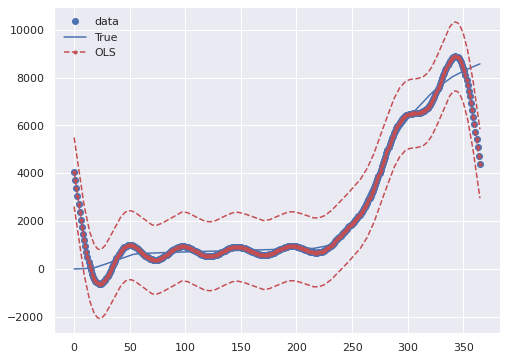

X_w, Infected
                            OLS Regression Results                            
Dep. Variable:               Infected   R-squared:                       0.970
Model:                            OLS   Adj. R-squared:                  0.969
Method:                 Least Squares   F-statistic:                     821.7
Date:                Fri, 18 Jun 2021   Prob (F-statistic):          7.22e-258
Time:                        20:13:19   Log-Likelihood:                -3499.8
No. Observations:                 365   AIC:                             7030.
Df Residuals:                     350   BIC:                             7088.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
T               -215.7138    1

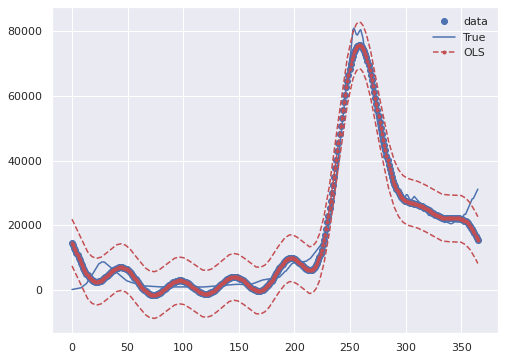

X_w, Recovered
                            OLS Regression Results                            
Dep. Variable:              Recovered   R-squared:                       0.942
Model:                            OLS   Adj. R-squared:                  0.940
Method:                 Least Squares   F-statistic:                     405.7
Date:                Fri, 18 Jun 2021   Prob (F-statistic):          1.44e-206
Time:                        20:13:19   Log-Likelihood:                -4337.9
No. Observations:                 365   AIC:                             8706.
Df Residuals:                     350   BIC:                             8764.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
T              -3.117e+04   1

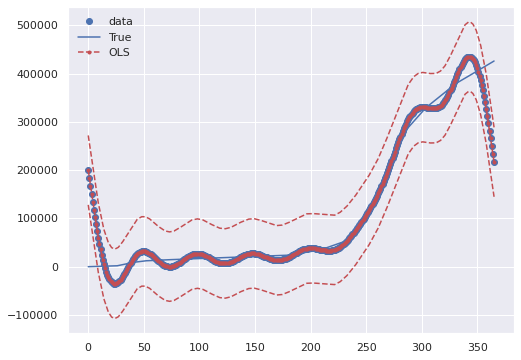

X_w, Confirmed
                            OLS Regression Results                            
Dep. Variable:              Confirmed   R-squared:                       0.941
Model:                            OLS   Adj. R-squared:                  0.939
Method:                 Least Squares   F-statistic:                     402.3
Date:                Fri, 18 Jun 2021   Prob (F-statistic):          5.64e-206
Time:                        20:13:20   Log-Likelihood:                -4373.4
No. Observations:                 365   AIC:                             8777.
Df Residuals:                     350   BIC:                             8835.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
T              -3.202e+04   1

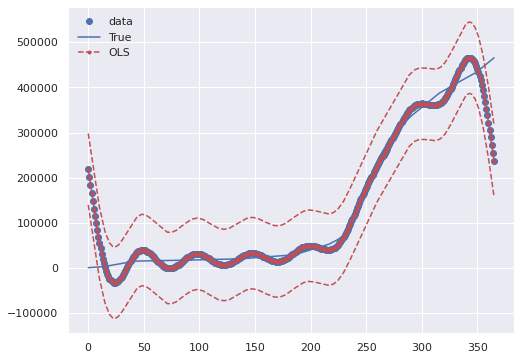

X_g, Fatal
                            OLS Regression Results                            
Dep. Variable:                  Fatal   R-squared:                       0.717
Model:                            OLS   Adj. R-squared:                  0.710
Method:                 Least Squares   F-statistic:                     112.5
Date:                Fri, 18 Jun 2021   Prob (F-statistic):           1.22e-92
Time:                        20:13:20   Log-Likelihood:                -3184.1
No. Observations:                 365   AIC:                             6386.
Df Residuals:                     356   BIC:                             6421.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------

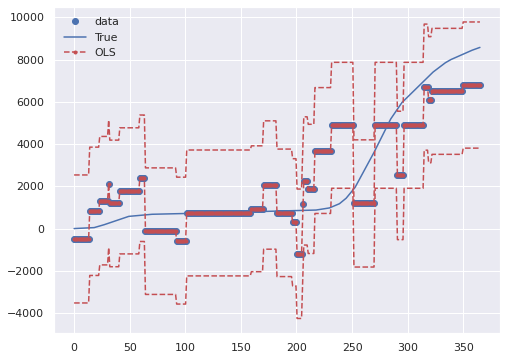

X_g, Infected
                            OLS Regression Results                            
Dep. Variable:               Infected   R-squared:                       0.706
Model:                            OLS   Adj. R-squared:                  0.700
Method:                 Least Squares   F-statistic:                     107.1
Date:                Fri, 18 Jun 2021   Prob (F-statistic):           5.99e-90
Time:                        20:13:20   Log-Likelihood:                -3918.9
No. Observations:                 365   AIC:                             7856.
Df Residuals:                     356   BIC:                             7891.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------

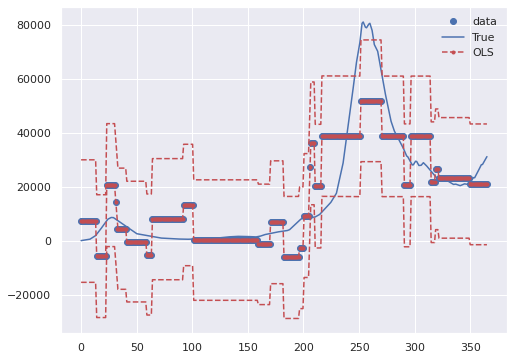

X_g, Recovered
                            OLS Regression Results                            
Dep. Variable:              Recovered   R-squared:                       0.731
Model:                            OLS   Adj. R-squared:                  0.725
Method:                 Least Squares   F-statistic:                     121.1
Date:                Fri, 18 Jun 2021   Prob (F-statistic):           1.00e-96
Time:                        20:13:20   Log-Likelihood:                -4617.6
No. Observations:                 365   AIC:                             9253.
Df Residuals:                     356   BIC:                             9288.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------

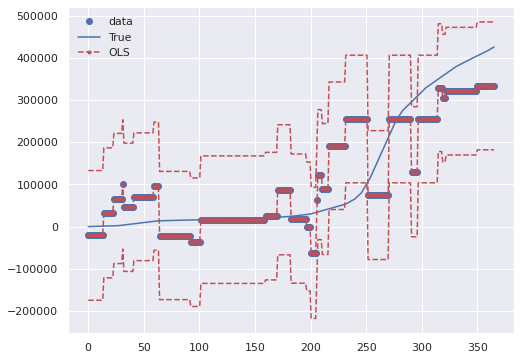

X_g, Confirmed
                            OLS Regression Results                            
Dep. Variable:              Confirmed   R-squared:                       0.749
Model:                            OLS   Adj. R-squared:                  0.744
Method:                 Least Squares   F-statistic:                     133.1
Date:                Fri, 18 Jun 2021   Prob (F-statistic):          4.05e-102
Time:                        20:13:20   Log-Likelihood:                -4638.8
No. Observations:                 365   AIC:                             9296.
Df Residuals:                     356   BIC:                             9331.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------

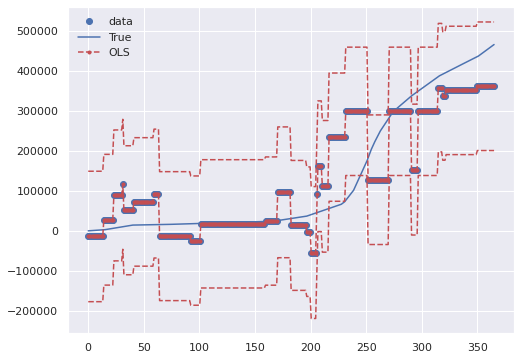

X_w_c, Fatal
                                 OLS Regression Results                                
Dep. Variable:                  Fatal   R-squared (uncentered):                   0.498
Model:                            OLS   Adj. R-squared (uncentered):              0.493
Method:                 Least Squares   F-statistic:                              89.64
Date:                Fri, 18 Jun 2021   Prob (F-statistic):                    7.73e-53
Time:                        20:13:20   Log-Likelihood:                         -3389.3
No. Observations:                 365   AIC:                                      6787.
Df Residuals:                     361   BIC:                                      6802.
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                     coef    std err          t      P>|t|      [0.025      0.975]
------------------------

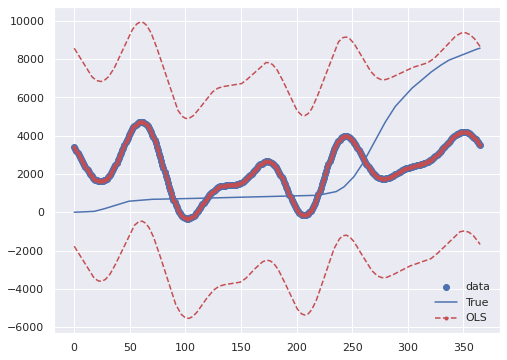

X_w_c, Infected
                                 OLS Regression Results                                
Dep. Variable:               Infected   R-squared (uncentered):                   0.452
Model:                            OLS   Adj. R-squared (uncentered):              0.446
Method:                 Least Squares   F-statistic:                              74.59
Date:                Fri, 18 Jun 2021   Prob (F-statistic):                    4.97e-46
Time:                        20:13:21   Log-Likelihood:                         -4122.6
No. Observations:                 365   AIC:                                      8253.
Df Residuals:                     361   BIC:                                      8269.
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                     coef    std err          t      P>|t|      [0.025      0.975]
---------------------

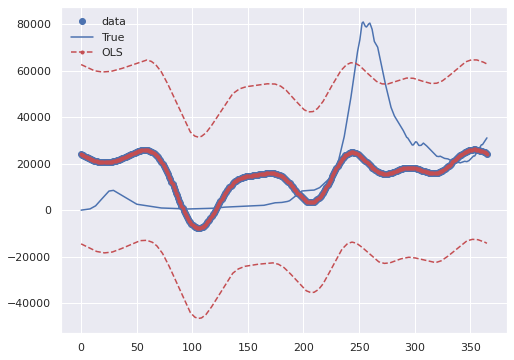

X_w_c, Recovered
                                 OLS Regression Results                                
Dep. Variable:              Recovered   R-squared (uncentered):                   0.464
Model:                            OLS   Adj. R-squared (uncentered):              0.458
Method:                 Least Squares   F-statistic:                              78.05
Date:                Fri, 18 Jun 2021   Prob (F-statistic):                    1.20e-47
Time:                        20:13:21   Log-Likelihood:                         -4831.0
No. Observations:                 365   AIC:                                      9670.
Df Residuals:                     361   BIC:                                      9686.
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------

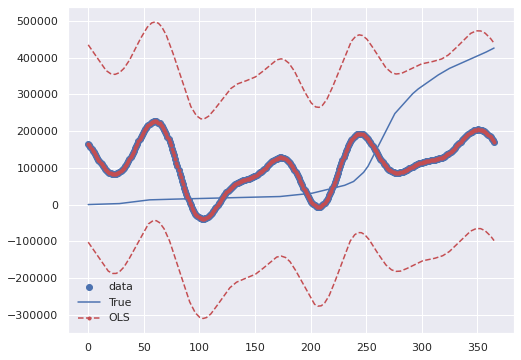

X_w_c, Confirmed
                                 OLS Regression Results                                
Dep. Variable:              Confirmed   R-squared (uncentered):                   0.493
Model:                            OLS   Adj. R-squared (uncentered):              0.487
Method:                 Least Squares   F-statistic:                              87.77
Date:                Fri, 18 Jun 2021   Prob (F-statistic):                    5.02e-52
Time:                        20:13:21   Log-Likelihood:                         -4863.4
No. Observations:                 365   AIC:                                      9735.
Df Residuals:                     361   BIC:                                      9750.
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------

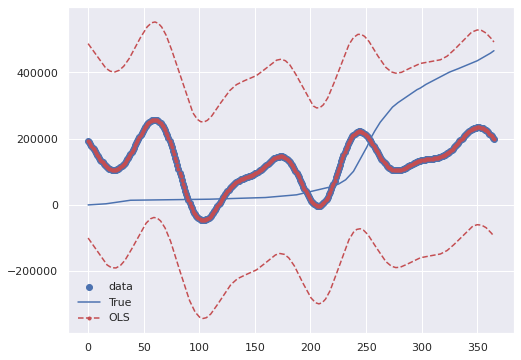

X_wg, Fatal
                            OLS Regression Results                            
Dep. Variable:                  Fatal   R-squared:                       0.987
Model:                            OLS   Adj. R-squared:                  0.986
Method:                 Least Squares   F-statistic:                     1209.
Date:                Fri, 18 Jun 2021   Prob (F-statistic):          3.50e-309
Time:                        20:13:21   Log-Likelihood:                -2617.2
No. Observations:                 365   AIC:                             5280.
Df Residuals:                     342   BIC:                             5370.
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------

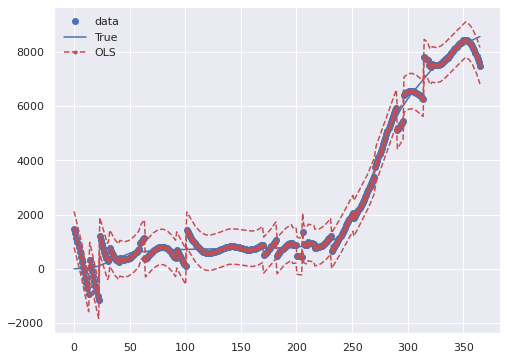

X_wg, Infected
                            OLS Regression Results                            
Dep. Variable:               Infected   R-squared:                       0.991
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                     1716.
Date:                Fri, 18 Jun 2021   Prob (F-statistic):               0.00
Time:                        20:13:21   Log-Likelihood:                -3282.5
No. Observations:                 365   AIC:                             6611.
Df Residuals:                     342   BIC:                             6701.
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------

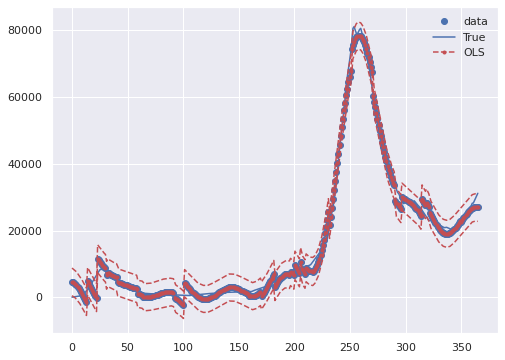

X_wg, Recovered
                            OLS Regression Results                            
Dep. Variable:              Recovered   R-squared:                       0.988
Model:                            OLS   Adj. R-squared:                  0.987
Method:                 Least Squares   F-statistic:                     1307.
Date:                Fri, 18 Jun 2021   Prob (F-statistic):          7.00e-315
Time:                        20:13:22   Log-Likelihood:                -4046.4
No. Observations:                 365   AIC:                             8139.
Df Residuals:                     342   BIC:                             8229.
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------

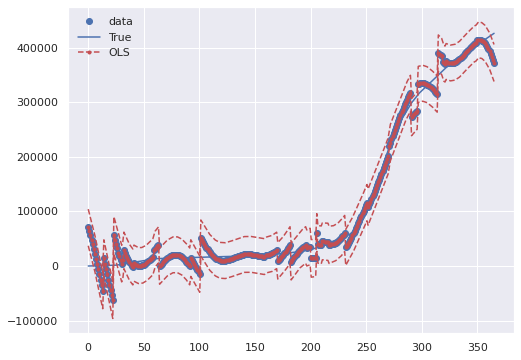

X_wg, Confirmed
                            OLS Regression Results                            
Dep. Variable:              Confirmed   R-squared:                       0.988
Model:                            OLS   Adj. R-squared:                  0.988
Method:                 Least Squares   F-statistic:                     1323.
Date:                Fri, 18 Jun 2021   Prob (F-statistic):          9.52e-316
Time:                        20:13:22   Log-Likelihood:                -4078.4
No. Observations:                 365   AIC:                             8203.
Df Residuals:                     342   BIC:                             8292.
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------

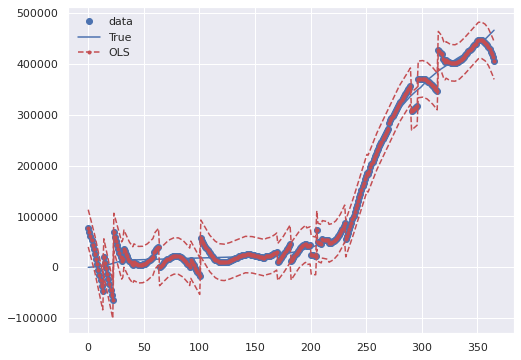

X_gp, Fatal
                            OLS Regression Results                            
Dep. Variable:                  Fatal   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 6.523e+28
Date:                Fri, 18 Jun 2021   Prob (F-statistic):               0.00
Time:                        20:13:22   Log-Likelihood:                 8061.3
No. Observations:                 365   AIC:                        -1.610e+04
Df Residuals:                     353   BIC:                        -1.605e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------

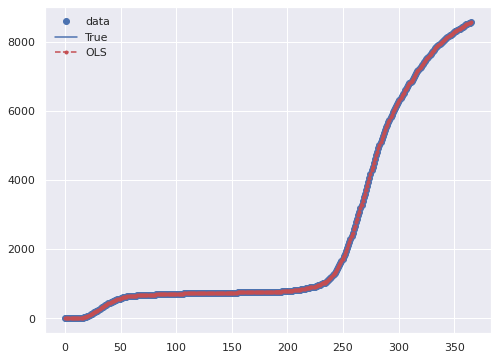

X_gp, Infected
                            OLS Regression Results                            
Dep. Variable:               Infected   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 3.687e+29
Date:                Fri, 18 Jun 2021   Prob (F-statistic):               0.00
Time:                        20:13:22   Log-Likelihood:                 7648.9
No. Observations:                 365   AIC:                        -1.527e+04
Df Residuals:                     353   BIC:                        -1.523e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------

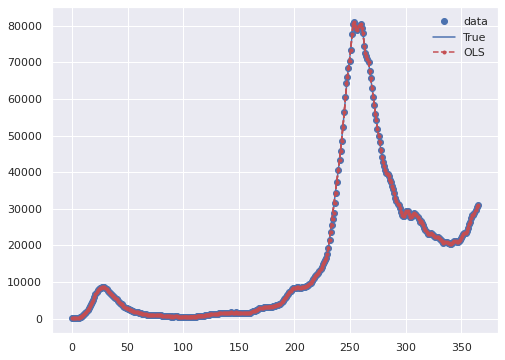

X_gp, Recovered
                            OLS Regression Results                            
Dep. Variable:              Recovered   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.538e+30
Date:                Fri, 18 Jun 2021   Prob (F-statistic):               0.00
Time:                        20:13:22   Log-Likelihood:                 7194.8
No. Observations:                 365   AIC:                        -1.437e+04
Df Residuals:                     353   BIC:                        -1.432e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------

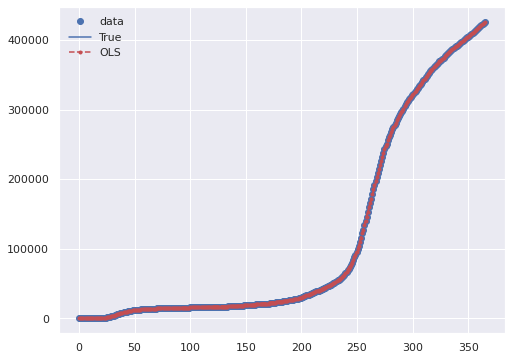

X_gp, Confirmed
                            OLS Regression Results                            
Dep. Variable:              Confirmed   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.498e+30
Date:                Fri, 18 Jun 2021   Prob (F-statistic):               0.00
Time:                        20:13:23   Log-Likelihood:                 7249.2
No. Observations:                 365   AIC:                        -1.447e+04
Df Residuals:                     353   BIC:                        -1.443e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------

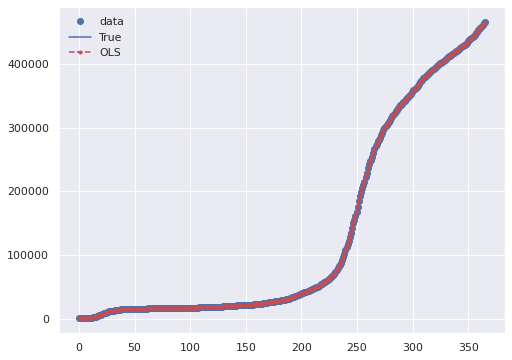

X_w_cg, Fatal
                            OLS Regression Results                            
Dep. Variable:                  Fatal   R-squared:                       0.844
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     159.2
Date:                Fri, 18 Jun 2021   Prob (F-statistic):          3.97e-134
Time:                        20:13:23   Log-Likelihood:                -3074.6
No. Observations:                 365   AIC:                             6175.
Df Residuals:                     352   BIC:                             6226.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------

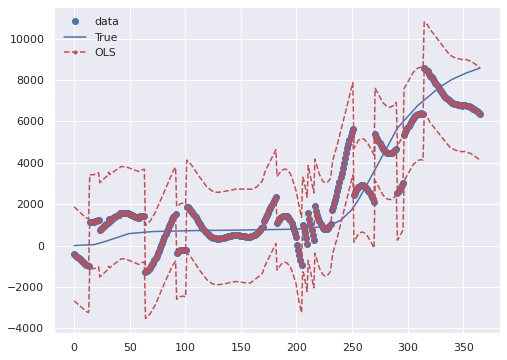

X_w_cg, Infected
                            OLS Regression Results                            
Dep. Variable:               Infected   R-squared:                       0.856
Model:                            OLS   Adj. R-squared:                  0.851
Method:                 Least Squares   F-statistic:                     174.1
Date:                Fri, 18 Jun 2021   Prob (F-statistic):          6.80e-140
Time:                        20:13:23   Log-Likelihood:                -3789.2
No. Observations:                 365   AIC:                             7604.
Df Residuals:                     352   BIC:                             7655.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------

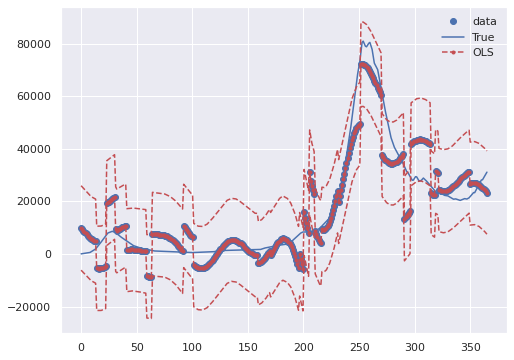

X_w_cg, Recovered
                            OLS Regression Results                            
Dep. Variable:              Recovered   R-squared:                       0.857
Model:                            OLS   Adj. R-squared:                  0.852
Method:                 Least Squares   F-statistic:                     175.7
Date:                Fri, 18 Jun 2021   Prob (F-statistic):          1.62e-140
Time:                        20:13:23   Log-Likelihood:                -4502.5
No. Observations:                 365   AIC:                             9031.
Df Residuals:                     352   BIC:                             9082.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------

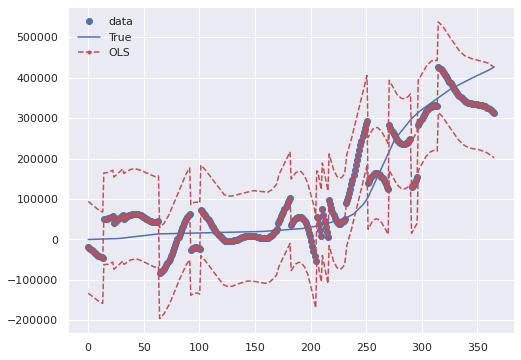

X_w_cg, Confirmed
                            OLS Regression Results                            
Dep. Variable:              Confirmed   R-squared:                       0.883
Model:                            OLS   Adj. R-squared:                  0.879
Method:                 Least Squares   F-statistic:                     221.2
Date:                Fri, 18 Jun 2021   Prob (F-statistic):          9.28e-156
Time:                        20:13:23   Log-Likelihood:                -4500.0
No. Observations:                 365   AIC:                             9026.
Df Residuals:                     352   BIC:                             9077.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------

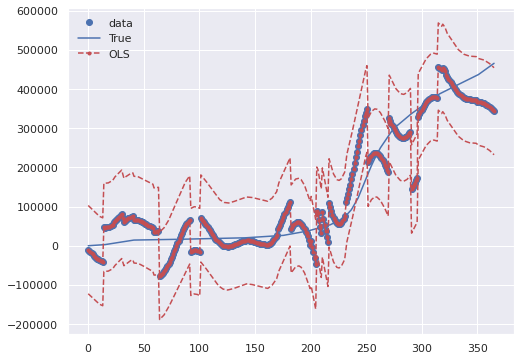

In [10]:
# Analyse all datsets seperately w.r.t Reproduction
x = np.linspace(0, 365, 365)
dependent = {'R_lwr': y_lwr, 'R': y, 'R_upr': y_upr}
independent = {'X_w': X_w, 'X_p': X_p, 'X_g': X_g,
               'X_w_c' : X_w_c, 'X_wgp' : X_wgp, 'X_wg' : X_wg, 
               'X_gp' : X_gp, 'X_wp' : X_wp, 'X_w_cgp' : X_w_cgp,
               'X_w_cg' : X_w_cg, 'X_w_cp': X_w_cp}
for X_key in independent:
    for y_key in dependent:
        print("{}, {}".format(X_key, y_key))
        mod = sm.OLS(dependent[y_key], independent[X_key])
        res = mod.fit()
        print(res.summary())

        prstd, iv_l, iv_u = wls_prediction_std(res)
        y_pred = res.predict(independent[X_key])
        fig, ax = plt.subplots(figsize=(8,6))
        ax.plot(x, y_pred, 'o', label="data")
        ax.plot(x, dependent[y_key], 'b-', label="True")
        ax.plot(x, res.fittedvalues, 'r--.', label="OLS")
        ax.plot(x, iv_u, 'r--')
        ax.plot(x, iv_l, 'r--')
        ax.legend(loc='best');
        plt.show()
        
# ...w.r.t pandemic curve
dependent = {'Fatal': X_p['Fatal'], 'Infected': X_p['Infected'], 
             'Recovered': X_p['Recovered'], 'Confirmed' : X_p['Confirmed']}
independent = {'X_w': X_w, 'X_g': X_g,
               'X_w_c' : X_w_c, 'X_wg' : X_wg, 
               'X_gp' : X_gp, 'X_w_cg' : X_w_cg}
for X_key in independent:
    for y_key in dependent:
        print("{}, {}".format(X_key, y_key))
        mod = sm.OLS(dependent[y_key], independent[X_key])
        res = mod.fit()
        print(res.summary())

        prstd, iv_l, iv_u = wls_prediction_std(res)
        y_pred = res.predict(independent[X_key])
        fig, ax = plt.subplots(figsize=(8,6))
        ax.plot(x, y_pred, 'o', label="data")
        ax.plot(x, dependent[y_key], 'b-', label="True")
        ax.plot(x, res.fittedvalues, 'r--.', label="OLS")
        ax.plot(x, iv_u, 'r--')
        ax.plot(x, iv_l, 'r--')
        ax.legend(loc='best');
        plt.show()

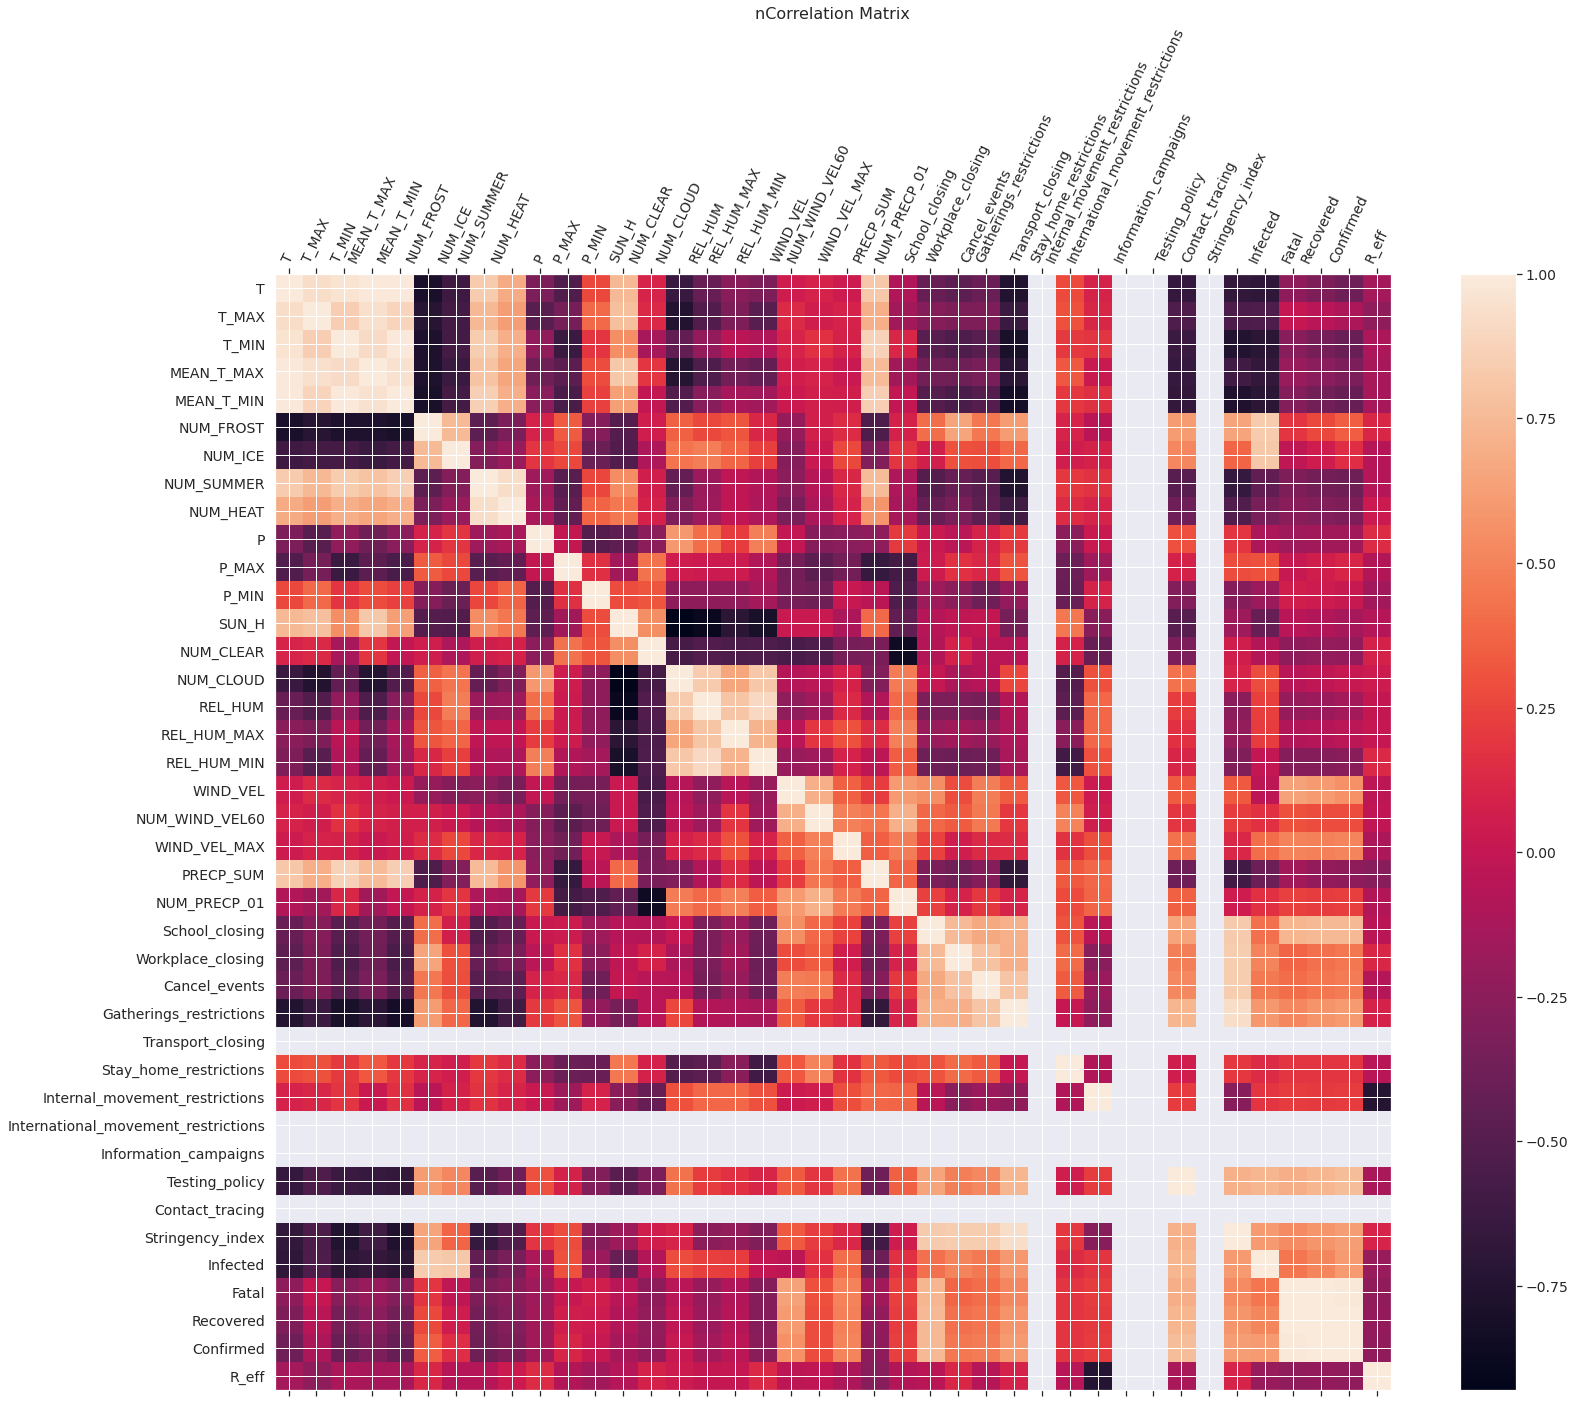

In [11]:
# Explore X, y datasets visually
Xy = pd.concat((X_wgp, pd.DataFrame(y, columns=['R_eff'])), axis=1)
Xy.reset_index(drop=True, inplace=True)

f = plt.figure(figsize=(25, 20))
plt.matshow(Xy.corr(), fignum=f.number)
plt.xticks(range(Xy.select_dtypes(['number']).shape[1]), 
           Xy.select_dtypes(['number']).columns, fontsize=14, rotation=65)
plt.yticks(range(Xy.select_dtypes(['number']).shape[1]), 
           Xy.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('nCorrelation Matrix', fontsize=16);
plt.show()

## Based on above insights, build a model for R_eff


Selected k Reg. Features: ['T', 'T_MAX', 'T_MIN', 'MEAN_T_MAX', 'MEAN_T_MIN', 'NUM_FROST', 'P', 'P_MIN', 'NUM_CLEAR', 'REL_HUM_MIN', 'WIND_VEL_MAX', 'PRECP_SUM']
                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.973
Model:                            OLS   Adj. R-squared (uncentered):              0.972
Method:                 Least Squares   F-statistic:                              1044.
Date:                Fri, 18 Jun 2021   Prob (F-statistic):                   2.62e-267
Time:                        20:14:49   Log-Likelihood:                          102.25
No. Observations:                 365   AIC:                                     -180.5
Df Residuals:                     353   BIC:                                     -133.7
Df Model:                          12                                                  
Covariance Type:            nonrobust        

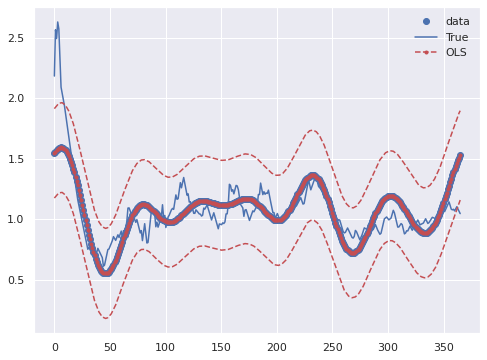

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.953
Model:                            OLS   Adj. R-squared:                  0.946
Method:                 Least Squares   F-statistic:                     135.4
Date:                Fri, 18 Jun 2021   Prob (F-statistic):          1.46e-182
Time:                        20:14:49   Log-Likelihood:                 517.92
No. Observations:                 365   AIC:                            -939.8
Df Residuals:                     317   BIC:                            -752.7
Df Model:                          47                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
T 

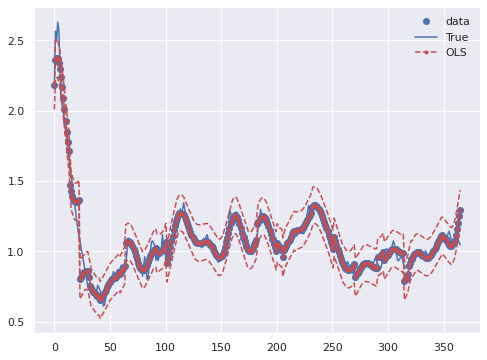

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.953
Model:                            OLS   Adj. R-squared:                  0.946
Method:                 Least Squares   F-statistic:                     135.4
Date:                Fri, 18 Jun 2021   Prob (F-statistic):          1.46e-182
Time:                        20:14:49   Log-Likelihood:                 517.92
No. Observations:                 365   AIC:                            -939.8
Df Residuals:                     317   BIC:                            -752.7
Df Model:                          47                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
T 

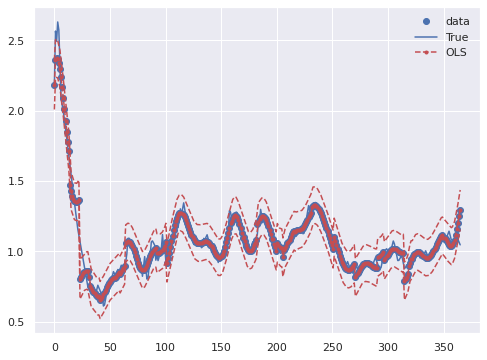

In [14]:
# Find best weather features
select_k = 12
#mutual_info_regression, f_regression
selector = SelectKBest(score_func=f_regression, k=select_k)
scaler = MinMaxScaler()
X_w = pd.DataFrame(scaler.fit_transform(X_w), columns=X_w.columns)
X_best = selector.fit_transform(X_w, y)
mask = selector.get_support() #list of booleans
features = [] # The list of your K best features
for bool, feature in zip(mask, X_w.columns):
    if bool:
        features.append(feature)
print('\nSelected k Reg. Features:', features)
X_w_best = X_w[features]

mod = sm.OLS(y, X_w_best)
res = mod.fit()
print(res.summary())

x = np.linspace(0,365,365)

prstd, iv_l, iv_u = wls_prediction_std(res)
y_pred = res.predict(X_w_best)
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(x, y_pred, 'o', label="data")
ax.plot(x, y, 'b-', label="True")
ax.plot(x, res.fittedvalues, 'r--.', label="OLS")
ax.plot(x, iv_u, 'r--')
ax.plot(x, iv_l, 'r--')
ax.legend(loc='best');
plt.show()
res = mod.fit()

# Try to build a good regressor
X = X_w_best#calculate_vif_(X_w_best, 5)

# Feature Engineering
# https://towardsdatascience.com/feature-engineering-for-machine-learning-3a5e293a5114
import scipy.stats as st
kernlen=2
nsig=1
k = np.linspace(-nsig, nsig, kernlen+1)
kern1d = np.diff(st.norm.cdf(k))
pd.options.mode.chained_assignment = None 
for col in X.columns:
    X["{}_log+1".format(col)] = (X[col]+1).transform(np.log) # Log transform
    X["{}_conv".format(col)] = np.convolve(X[col], kern1d, 'same') # Convolution
    X["{}_pow2".format(col)] = X[col]*X[col] # Power transform
pd.options.mode.chained_assignment = 'warn' 

scaler = MinMaxScaler()
X_g = pd.DataFrame(scaler.fit_transform(X_g), columns=X_g.columns)
X = pd.concat((X, X_g), axis=1)
mod = sm.OLS(y, X)
res = mod.fit()
print(res.summary())

prstd, iv_l, iv_u = wls_prediction_std(res)
y_pred = res.predict(X)
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(x, y_pred, 'o', label="data")
ax.plot(x, y, 'b-', label="True")
ax.plot(x, res.fittedvalues, 'r--.', label="OLS")
ax.plot(x, iv_u, 'r--')
ax.plot(x, iv_l, 'r--')
ax.legend(loc='best');
plt.show()
res = mod.fit()



# Remove statistically insignificant (p 0.05) features, they could break the model
insignificant = [
                ]
'''
insignificant = ['Stringency_index', 
                 'Information_campaigns', 
                 'REL_HUM', 
                 'SUN_H_conv', 
                 'NUM_WIND_VEL60_log+1',
                 'NUM_ICE_conv',
                 'NUM_CLEAR_log+1',
                 'NUM_PRECP_01_log+1',
                 'P_MAX',
                 'NUM_WIND_VEL60_conv',
                 'REL_HUM_MIN_log+1',
                 'REL_HUM_conv',
                 'NUM_CLOUD',
                 'NUM_PRECP_01_conv',
                 'PRECP_SUM',
                 'PRECP_SUM_conv',
                 'NUM_FROST',
                 'P_MAX_conv'
                ]
'''


X = X.drop(columns=insignificant)
scaler = MinMaxScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

X_const_cols = X.columns[X.nunique() <= 1]
#for col in X.columns:
#    if col not in X_const_cols:
        #X[col] = X[col]*X[col]+1
        #X[col], _, = boxcox(X[col], lmbda=None, alpha=None)
mod = sm.OLS(y, X)
res = mod.fit()
print(res.summary())

prstd, iv_l, iv_u = wls_prediction_std(res)
y_pred = res.predict(X)
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(x, y_pred, 'o', label="data")
ax.plot(x, y, 'b-', label="True")
ax.plot(x, res.fittedvalues, 'r--.', label="OLS")
ax.plot(x, iv_u, 'r--')
ax.plot(x, iv_l, 'r--')
ax.legend(loc='best');
plt.show()
res = mod.fit()


mod_lwr = sm.OLS(y_lwr, X)
res_lwr = mod.fit()
#print('\n Selected Featres OLS for R_eff_lwr')
#print(res_lwr.summary())

mod = sm.OLS(y_upr, X)
res_upr = mod.fit()
#print('\n Selected Featres OLS for R_eff_upr')
#print(res_upr.summary())


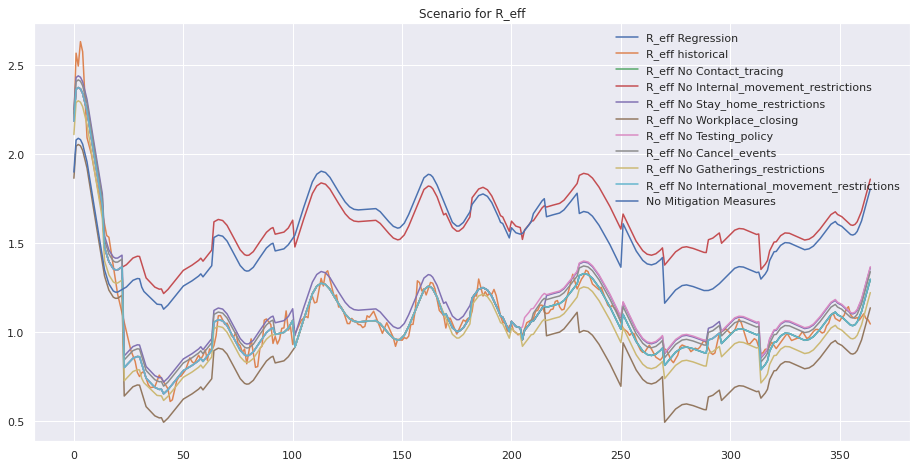

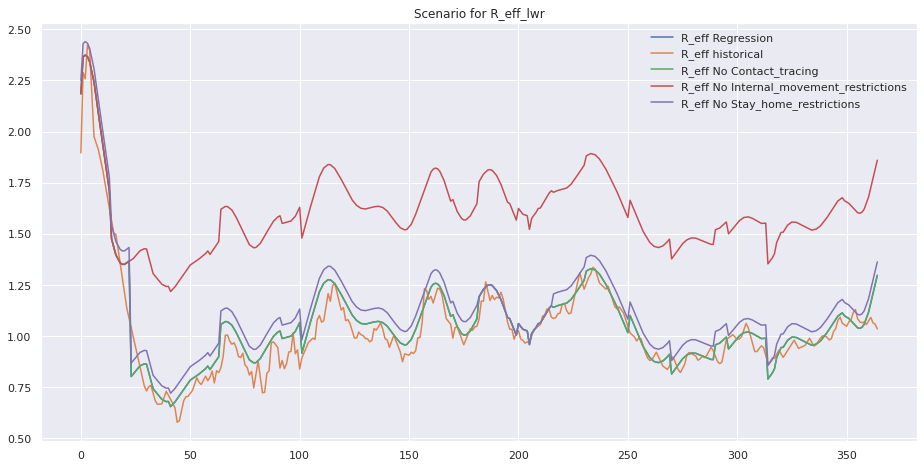

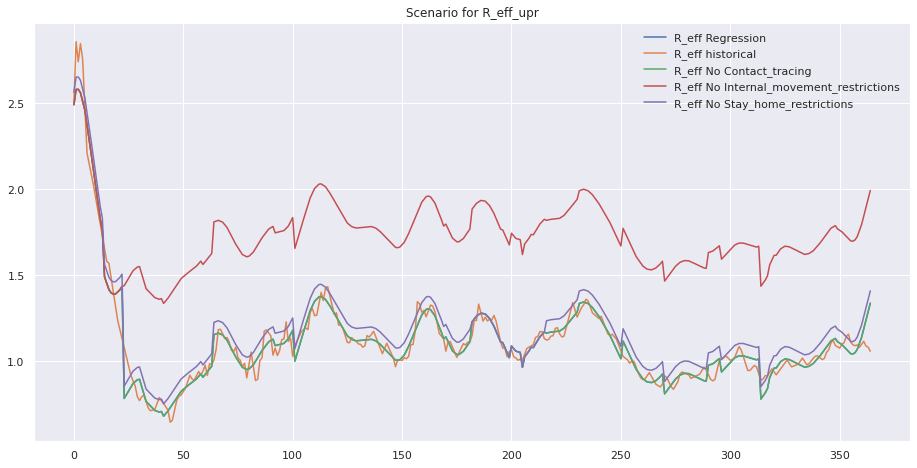

In [15]:
# Still some multicolinearity but we need some restriction still in the dataset
# Let's test the model an see how it behaves:
#plt.plot(res.predict(X), label ='R_eff Regression')
#plt.plot(y, label = 'R_eff historical')
#plt.plot(res.predict(X.assign(Contact_tracing = 0)), label = 'R_eff No Contact_tracing')
#plt.plot(res.predict(X.assign(Internal_movement_restrictions = 0)), label = 'R_eff No Internal_movement_restrictions')
#plt.plot(res.predict(X.assign(Stay_home_restrictions = 0)), label = 'R_eff No Stay_home_restrictions')
#plt.title('Scenario for R_eff')
#plt.legend()
#plt.show()

plt.plot(res.predict(X), label ='R_eff Regression')
plt.plot(y, label = 'R_eff historical')
plt.plot(res.predict(X.assign(Contact_tracing = 0)), label = 'R_eff No Contact_tracing')
plt.plot(res.predict(X.assign(Internal_movement_restrictions = 0)), label = 'R_eff No Internal_movement_restrictions')
plt.plot(res.predict(X.assign(Stay_home_restrictions = 0)), label = 'R_eff No Stay_home_restrictions')
plt.plot(res.predict(X.assign(Workplace_closing = 0)), label = 'R_eff No Workplace_closing')
plt.plot(res.predict(X.assign(Testing_policy = 0)), label = 'R_eff No Testing_policy')
plt.plot(res.predict(X.assign(Cancel_events = 0)), label = 'R_eff No Cancel_events')
plt.plot(res.predict(X.assign(Gatherings_restrictions = 0)), label = 'R_eff No Gatherings_restrictions')
plt.plot(res.predict(X.assign(International_movement_restrictions = 0)), label = 'R_eff No International_movement_restrictions')
plt.plot(res.predict(X.assign(International_movement_restrictions = 0,
                             Gatherings_restrictions = 0,
                              Cancel_events = 0,
                              Testing_policy = 0,
                              Workplace_closing = 0,
                              Stay_home_restrictions = 0,
                              Internal_movement_restrictions = 0,
                              Contact_tracing = 0
                             )), label = 'No Mitigation Measures')
plt.title('Scenario for R_eff')
plt.legend()
plt.show()

plt.plot(res_lwr.predict(X), label ='R_eff Regression')
plt.plot(y_lwr, label = 'R_eff historical')
plt.plot(res_lwr.predict(X.assign(Contact_tracing = 0)), label = 'R_eff No Contact_tracing')
plt.plot(res_lwr.predict(X.assign(Internal_movement_restrictions = 0)), label = 'R_eff No Internal_movement_restrictions')
plt.plot(res_lwr.predict(X.assign(Stay_home_restrictions = 0)), label = 'R_eff No Stay_home_restrictions')
plt.title('Scenario for R_eff_lwr')
plt.legend()
plt.show()

plt.plot(res_upr.predict(X), label ='R_eff Regression')
plt.plot(y_upr, label = 'R_eff historical')
plt.plot(res_upr.predict(X.assign(Contact_tracing = 0)), label = 'R_eff No Contact_tracing')
plt.plot(res_upr.predict(X.assign(Internal_movement_restrictions = 0)), label = 'R_eff No Internal_movement_restrictions')
plt.plot(res_upr.predict(X.assign(Stay_home_restrictions = 0)), label = 'R_eff No Stay_home_restrictions')
plt.title('Scenario for R_eff_upr')
plt.legend()
plt.show()

0.9407605205762894


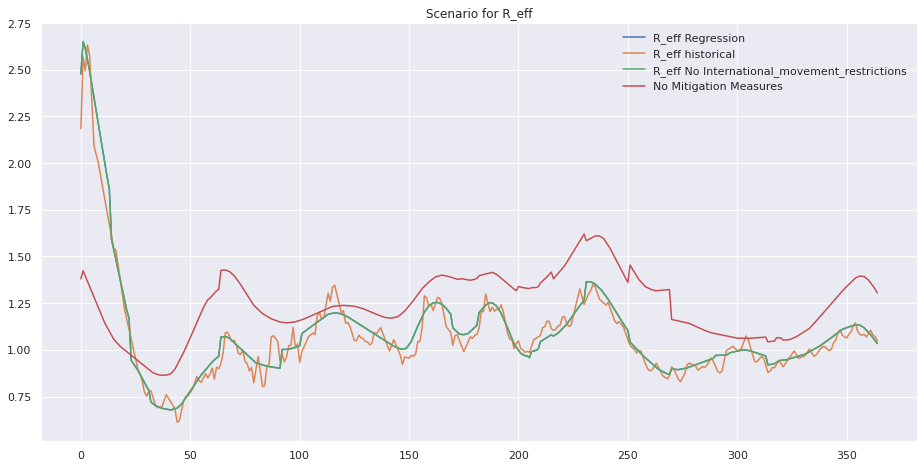

0.9270289093885915
0.9403438635099347


In [16]:
# Give MLP Regressor a shot
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from copy import deepcopy
from sklearn.model_selection import KFold

X_train, X_test, y_train, y_test = train_test_split(X.to_numpy(), y, random_state=1, test_size=0.3)

res = MLPRegressor(random_state=1, max_iter=2500, 
                   hidden_layer_sizes = (365, 365, 365, 365),
                   activation='relu', solver='adam',
                   learning_rate_init = 1e-3, shuffle=True,
                   tol=1e-9, early_stopping=True, validation_fraction=0.1,
                   batch_size=10, warm_start= False
                  ).fit(X_train, y_train)
print(res.score(X_test, y_test))



plt.plot(res.predict(X), label ='R_eff Regression')
plt.plot(y, label = 'R_eff historical')
#plt.plot(res.predict(X.assign(Contact_tracing = 0)), label = 'R_eff No Contact_tracing')
#plt.plot(res.predict(X.assign(Internal_movement_restrictions = 0)), label = 'R_eff No Internal_movement_restrictions')
#plt.plot(res.predict(X.assign(Stay_home_restrictions = 0)), label = 'R_eff No Stay_home_restrictions')
#plt.plot(res.predict(X.assign(Workplace_closing = 0)), label = 'R_eff No Workplace_closing')
#plt.plot(res.predict(X.assign(Testing_policy = 0)), label = 'R_eff No Testing_policy')
#plt.plot(res.predict(X.assign(Cancel_events = 0)), label = 'R_eff No Cancel_events')
#plt.plot(res.predict(X.assign(Gatherings_restrictions = 0)), label = 'R_eff No Gatherings_restrictions')
plt.plot(res.predict(X.assign(International_movement_restrictions = 0)), label = 'R_eff No International_movement_restrictions')
plt.plot(res.predict(X.assign(International_movement_restrictions = 0,
                             Gatherings_restrictions = 0,
                              Cancel_events = 0,
                              Testing_policy = 0,
                              Workplace_closing = 0,
                              Stay_home_restrictions = 0,
                              Internal_movement_restrictions = 0,
                              Contact_tracing = 0
                             )), label = 'No Mitigation Measures')
plt.title('Scenario for R_eff')
plt.legend()
plt.show()


#Lets look at lowr and upr bounds
X_train, X_test, y_train, y_test = train_test_split(X, y_lwr, random_state=1, test_size=0.3)
res_lwr = MLPRegressor(random_state=1, max_iter=2500, 
                   hidden_layer_sizes = (365, 365, 365, 365),
                   activation='relu', solver='adam',
                   learning_rate_init = 1e-3, shuffle=True,
                   tol=1e-9, early_stopping=True, validation_fraction=0.1
                  ).fit(X_train, y_train)

print(res_lwr.score(X_test, y_test))

X_train, X_test, y_train, y_test = train_test_split(X, y_upr, random_state=1, test_size=0.3)
res_upr = MLPRegressor(random_state=1, max_iter=2500, 
                   hidden_layer_sizes = (365, 365, 365, 365),
                   activation='relu', solver='adam',
                   learning_rate_init = 1e-3, shuffle=True,
                   tol=1e-9, early_stopping=True, validation_fraction=0.1
                  ).fit(X_train, y_train)

print(res_upr.score(X_test, y_test))

## SEIR-FV Model with Reinfection, ICUs and Hospitalizations Capacities, Adjusted for Age-Groups and Virus Reproduction depending on Meteorological Effects and Government Policies
Improved SIR Model taking into account weather and effective reproduction number based on various mitigation scenarios

In [18]:
# SIR disease model
# Source: https://scipython.com/book/chapter-8-scipy/additional-examples/the-sir-epidemic-model/
# https://www.rki.de/DE/Content/InfAZ/N/Neuartiges_Coronavirus/Modellierung_Deutschland.pdf?__blob=publicationFile

# http://sherrytowers.com/2012/12/11/sir-model-with-age-classes/
# ICUs
# file:///tmp/mozilla_lorenz0/Austria%20Prognosis%20and%20actual%20COVID-19%20Diseased.pdf
# file:///tmp/mozilla_lorenz0/Austria%20Prognosis%20and%20actual%20COVID-19%20Diseased.pdf
ICUs_free = 1072 # Mar 27 2020
HOSPs_free = 21682 # Mar 27 2020
VAC_full_effect = 0.95 #Probability of any vaccine preventing contraction, cannot infect others
VAC_once_effect = 0.95 #Probability of any vaccine preventing death, can infect others

def deriv(t, y, N, gamma, delta, epsilon, rho, t_vac_once_start, t_vac_full_start, R_eff):
    y_i = ()
    ICUs_required = 0
    HOSPs_requried = 0
    N_sum = sum(N)
    numvars = 7
    
    #Compute ICUs and Hospital Beds required
    for i in range(0,len(y),numvars):
        S, E, I, R, F, V1, V2 = y[i:i+numvars]
        ICUs_required+=I*epsilon[i//numvars]*rho[i//numvars]
        HOSPs_requried+=I*epsilon[i//numvars]*rho[i//numvars]
    HOSPs_requried - ICUs_required
    
    # Hospital beds or ICUs full
    omega = float(ICUs_required > ICUs_free)
    kappa = float(HOSPs_requried > HOSPs_free)

    #Time until Exposed move to Infected
    alpha = 1.0/3.0 # https://www.rki.de/DE/Content/InfAZ/N/Neuartiges_Coronavirus/Modellierung_Deutschland.pdf?__blob=publicationFile
    
    # Inter group contractions
    beta = [R_eff[int(round(t))]*(gamma[i]+delta_i) for i, delta_i in enumerate(delta)]
    
    # Intra group contractions
    beta_avg = sum(beta)/len(beta)
    beta = [0.5*(beta_avg+b) for b in beta]

    
    for i in range(0,len(y),numvars):
        S, E, I, R, F, V1, V2 = y[i:i+numvars]
        
        # Single and Double Vaccinations
        dV1dt = S * vac_once_per_day/N_sum*VAC_once_effect if t >= t_vac_once_start else 0
        dV2dt = S * vac_full_per_day/N_sum*VAC_full_effect if t >= t_vac_full_start else 0

        # Decrease in Suspectables
        dSdt = -beta[i//numvars] * S * I / N[i//numvars] - dV2dt if S >= 0 else +0.0
            
        # Probability that and individual of a group has been succesfully vaccinated once
        theta = V1/S 
        
        # Suspectable to Exposed minus Exposed to Infected
        dEdt = beta[i//numvars] * S * I / N[i//numvars] - alpha * E
        
        # Infected to Recovered
        dRdt = (1+theta)* I * gamma[i//numvars] * (1 - (epsilon[i//numvars]*rho[i//numvars]*omega + rho[i//numvars]*kappa))
        
        # Infected to Fatalities
        dFdt = (1-theta)* I * delta[i//numvars] * (1 + (epsilon[i//numvars]*rho[i//numvars]*omega + rho[i//numvars]*kappa))
        
        # Exposed to Infected minus Recovered + Fatalities
        dIdt = alpha * E - dRdt - dFdt
        
        # Reinfection after reocivering possible after 5-7 months: 
        # EXPERIMENTAL
        # https://www.cell.com/immunity/fulltext/S1074-7613(20)30445-3
        # How ist it with Vaccines?
        dSdt += (1.0/180.0)*R + (1.0/210.0)*V2
        dV2dt += -(1.0/210.0)*V2
        dV1dt += -(1.0/210.0)*V1
        dRdt += -(1.0/180.0)*R
        
        y_i += dSdt, dEdt, dIdt, dRdt, dFdt, dV1dt, dV2dt
    return y_i

from scipy.integrate import solve_ivp
def run_sim(N, E0, I0, R0, F0, V10, V20, gamma, delta, epsilon, rho, t, deriv, t_vac_once_start, t_vac_full_start, R):
    #Make y0:
    y0 = ()
    for n in N:
        S0 = n - E0- I0 - R0 - F0 - V20
        y0 += (S0, E0, I0, R0, F0, V10, V20)

    ret = solve_ivp(fun=deriv, t_span=(min(t), max(t)), y0=y0, t_eval=t, max_step=0.25,
                    method='RK23',
                    args=(N, gamma, delta, epsilon, rho, t_vac_once_start, t_vac_full_start, R))
    return [*ret['y']]

## Hypothetical Scenarios for 2020-2021

8901064.000000004

SCENARIO END STATE: Constant R
Numerical Sanity check: S+E+I+R+F+V = N Average Error: 6.20881716410319e-10
Suspectable: 3442342 to 5107708
Exposed: 0 to 93569
Infected: 0 to 394263
Fatalities: 286104 to 357939
Recovered: 3231907 to 4325403
Vaccinated Fully: 301828 to 379930
Vaccinated Once: 823100 to 979129
Model evaluated w.r.t. historical data:
R2 -2798.0571807176316
EV -908.5582961300184
RMSE 4639392718452.259
RMSLE 17.369344017301284


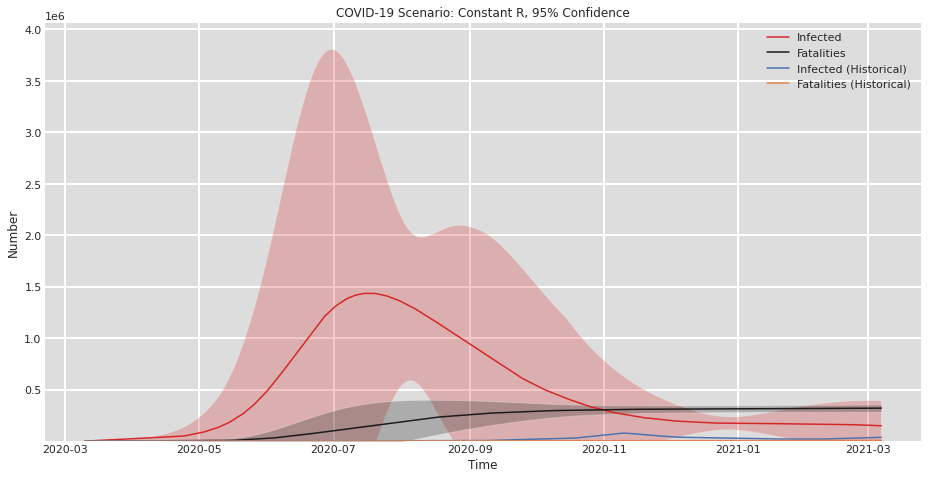

8901063.999999998

SCENARIO END STATE: Historical R
Numerical Sanity check: S+E+I+R+F+V = N Average Error: -5.587935447692871e-09
Suspectable: 7790920 to 8370888
Exposed: 0 to 8421
Infected: 0 to 45153
Fatalities: 0 to 32924
Recovered: 0 to 367651
Vaccinated Fully: 656661 to 702321
Vaccinated Once: 1778094 to 1897765
Model evaluated w.r.t. historical data:
R2 0.43317318594898496
EV 0.522800594065255
RMSE 5772099660.82824
RMSLE 1.1144727126879117


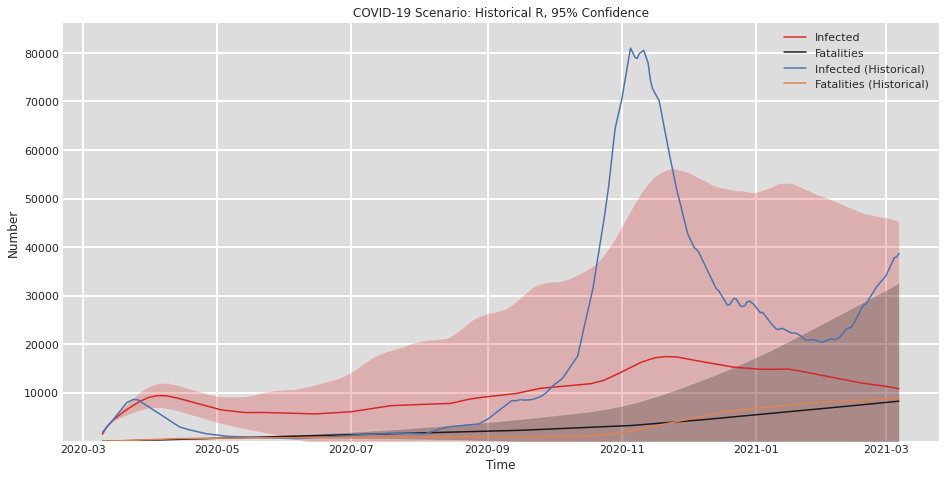

8901063.999999994

SCENARIO END STATE: Regression R
Numerical Sanity check: S+E+I+R+F+V = N Average Error: 0.0
Suspectable: 7722914 to 8392867
Exposed: 0 to 10363
Infected: 0 to 56654
Fatalities: 0 to 39289
Recovered: 0 to 421140
Vaccinated Fully: 651840 to 703582
Vaccinated Once: 1766161 to 1900498
Model evaluated w.r.t. historical data:
R2 0.4894610842571627
EV 0.571085531415923
RMSE 5102736390.531598
RMSLE 1.1355169354755075


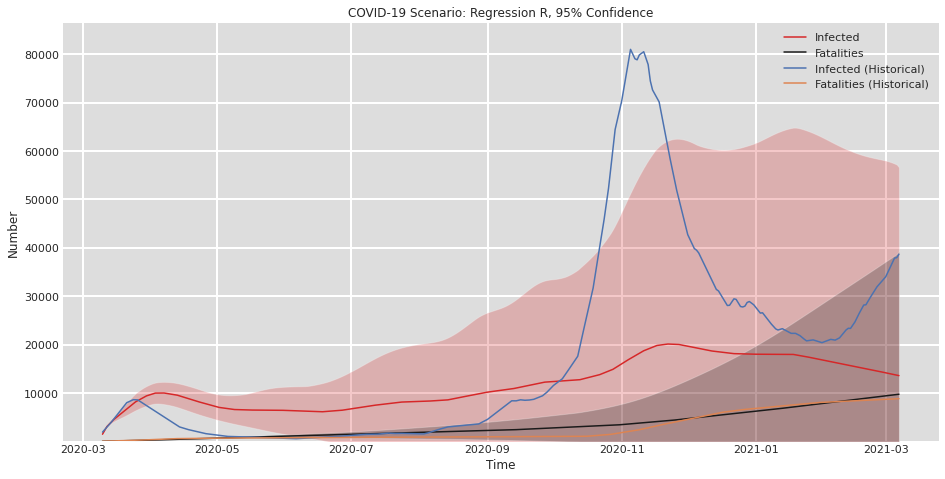

8901064.000000002

SCENARIO END STATE: No Events Canceled
Numerical Sanity check: S+E+I+R+F+V = N Average Error: 6.20881716410319e-09
Suspectable: 7463137 to 8482057
Exposed: 0 to 13100
Infected: 0 to 76859
Fatalities: 0 to 81295
Recovered: 0 to 637208
Vaccinated Fully: 630254 to 711576
Vaccinated Once: 1709170 to 1921922


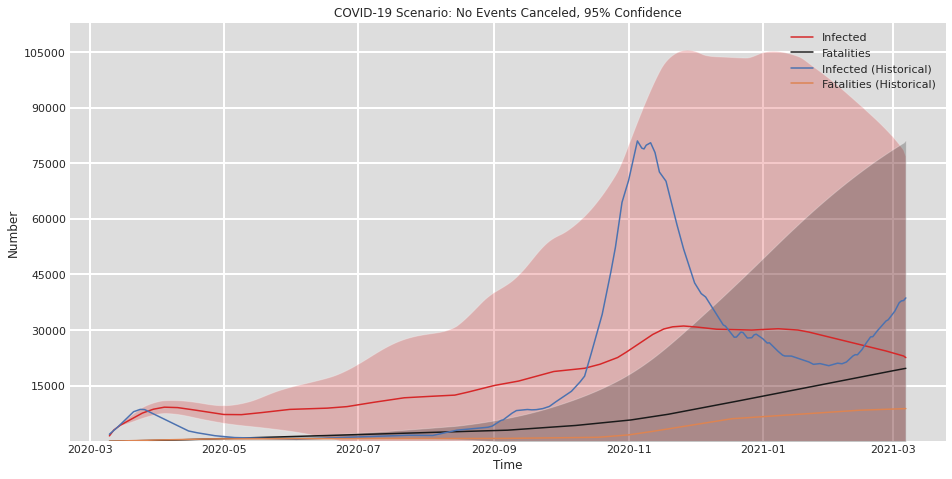

8901063.999999994

SCENARIO END STATE: No Contact Tracing
Numerical Sanity check: S+E+I+R+F+V = N Average Error: 0.0
Suspectable: 7722914 to 8392867
Exposed: 0 to 10363
Infected: 0 to 56654
Fatalities: 0 to 39289
Recovered: 0 to 421140
Vaccinated Fully: 651840 to 703582
Vaccinated Once: 1766161 to 1900498


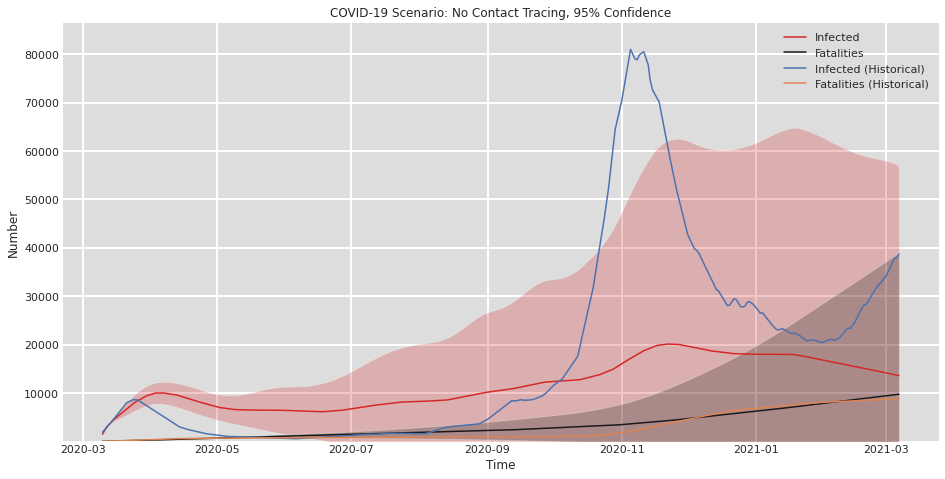

8901063.999999996

SCENARIO END STATE: No Internal Restrictions
Numerical Sanity check: S+E+I+R+F+V = N Average Error: 1.241763432820638e-09
Suspectable: 0 to 11119226
Exposed: 11079 to 68063
Infected: 0 to 455799
Fatalities: 0 to 528726
Recovered: 0 to 9001490
Vaccinated Fully: 0 to 966954
Vaccinated Once: 0 to 2629591


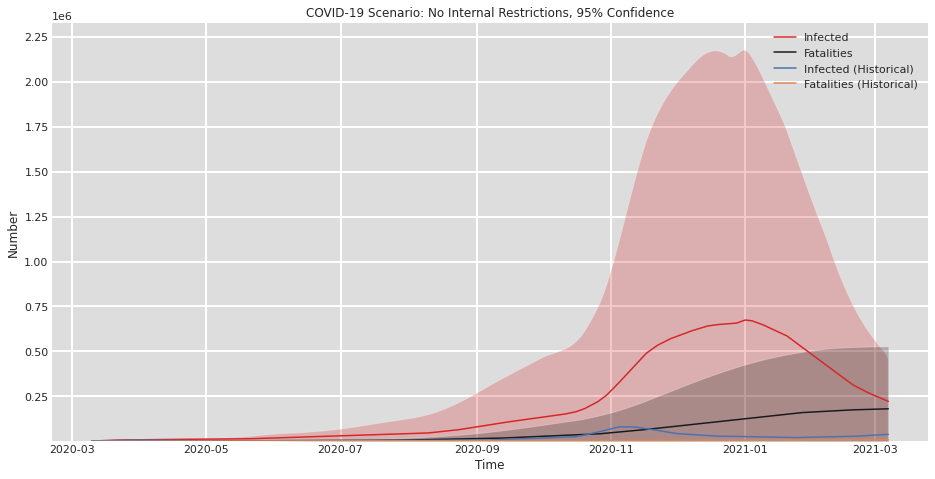

8901063.999999998

SCENARIO END STATE: No Workplace Closing
Numerical Sanity check: S+E+I+R+F+V = N Average Error: -4.967053731282552e-09
Suspectable: 8007840 to 8261413
Exposed: 0 to 2279
Infected: 0 to 11808
Fatalities: 0 to 8774
Recovered: 0 to 197542
Vaccinated Fully: 672823 to 694436
Vaccinated Once: 1819591 to 1877749


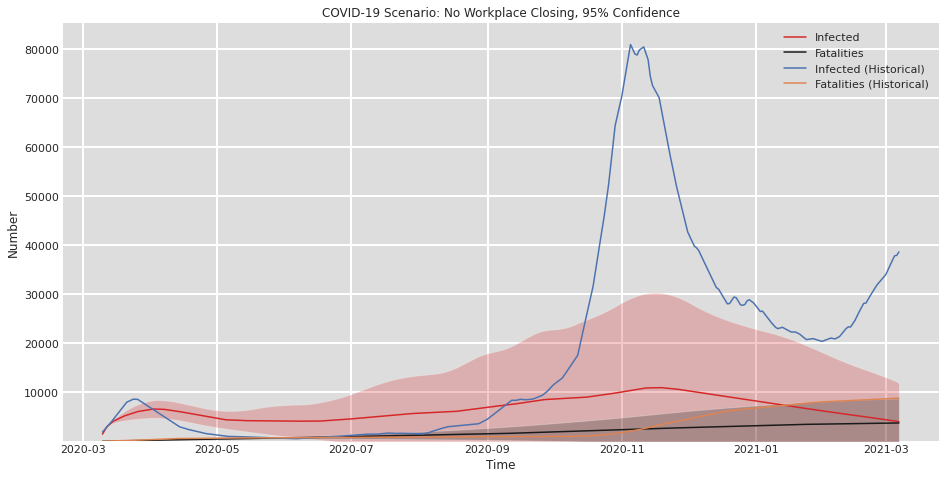

8901064.0

SCENARIO END STATE: No Stay Home Restrictions
Numerical Sanity check: S+E+I+R+F+V = N Average Error: 6.20881716410319e-09
Suspectable: 7995347 to 8264348
Exposed: 0 to 2474
Infected: 0 to 12952
Fatalities: 0 to 9194
Recovered: 0 to 209282
Vaccinated Fully: 671818 to 694630
Vaccinated Once: 1817073 to 1878175


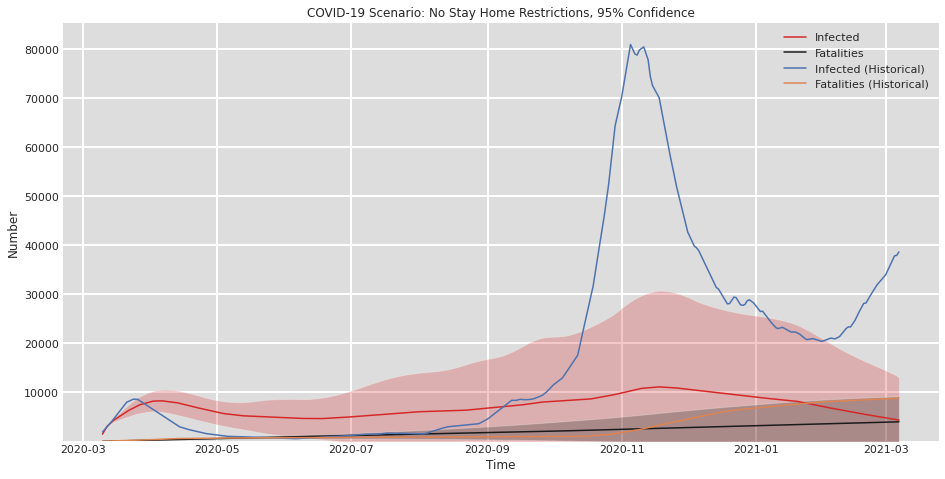

8901064.0

SCENARIO END STATE: No Gathering Restrictions
Numerical Sanity check: S+E+I+R+F+V = N Average Error: 0.0
Suspectable: 8012176 to 8261114
Exposed: 0 to 1935
Infected: 0 to 10374
Fatalities: 0 to 8923
Recovered: 0 to 194665
Vaccinated Fully: 672991 to 694452
Vaccinated Once: 1819810 to 1877858


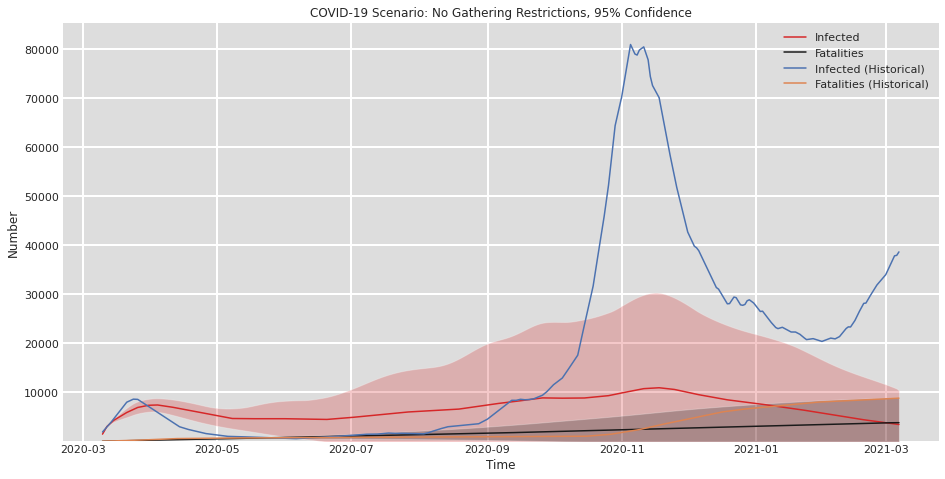

8901064.000000002

SCENARIO END STATE: No School Closings
Numerical Sanity check: S+E+I+R+F+V = N Average Error: 6.20881716410319e-09
Suspectable: 7501481 to 8480897
Exposed: 0 to 15475
Infected: 0 to 83837
Fatalities: 0 to 63314
Recovered: 0 to 602943
Vaccinated Fully: 634833 to 710667
Vaccinated Once: 1722518 to 1918898


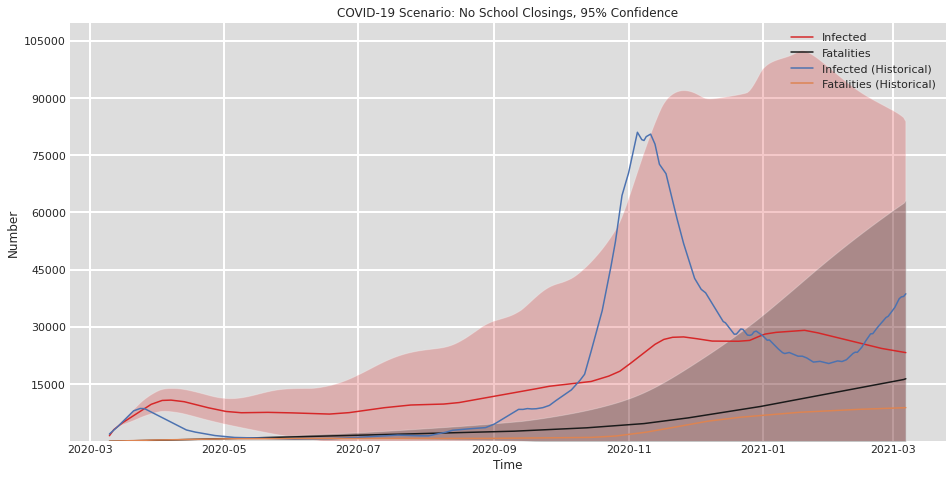

8901064.000000011

SCENARIO END STATE: No Mitigation Measures
Numerical Sanity check: S+E+I+R+F+V = N Average Error: 1.862645149230957e-09
Suspectable: 2953645 to 10580036
Exposed: 0 to 143493
Infected: 0 to 788875
Fatalities: 0 to 451138
Recovered: 0 to 4280300
Vaccinated Fully: 297991 to 864702
Vaccinated Once: 869597 to 2307723


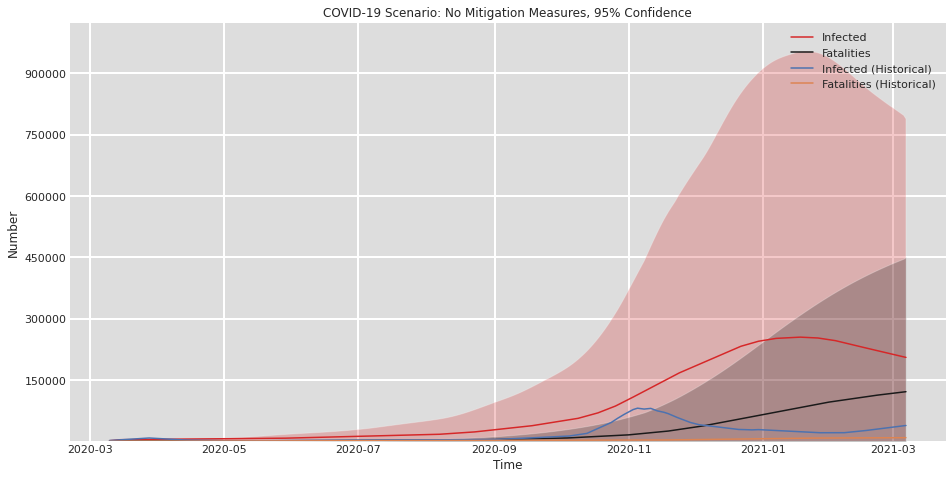

8901064.000000004

SCENARIO END STATE: Zero-Covid Measures
Numerical Sanity check: S+E+I+R+F+V = N Average Error: 2.483526865641276e-09
Suspectable: 8033008 to 8256829
Exposed: 0 to 3921
Infected: 0 to 17622
Fatalities: 0 to 6348
Recovered: 0 to 163967
Vaccinated Fully: 676214 to 693514
Vaccinated Once: 1829789 to 1874862


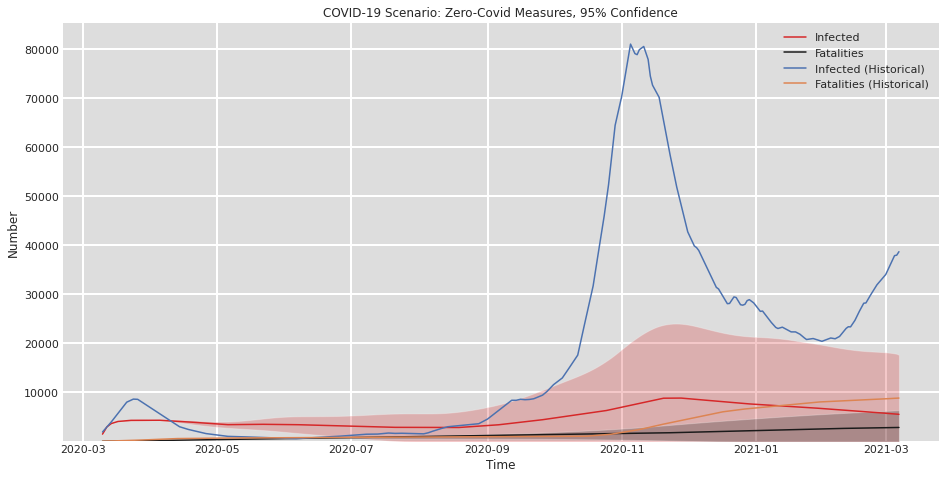

In [32]:
# Scenarios: Validate model with hisorical R data from 1 year of corona
# and compute what-if scenarios
# https://de.wikipedia.org/wiki/COVID-19-Pandemie_in_%C3%96sterreich#Ma%C3%9Fnahmen_im_Gesundheitsbereich
infected = aut_cov['Infected'].to_numpy()
fatal = aut_cov['Fatal'].to_numpy()
recovered = aut_cov['Recovered'].to_numpy()
t_vac_full_start = 317 #Full vaccinations 15.01.2021
t_vac_once_start = 298 #Full vaccinations 27.12.2020
duration = 363#len(aut_cov['Infected'].to_numpy())

scores = {'R2': r2_score,
          'EV': explained_variance_score,
          'RMSE': mean_squared_error,
          'RMSLE': mean_squared_log_error
         }


scenarios = {
    'Constant R' : [[y_lwr[0]]*365, [y[0]]*365, [y_upr[0]]*365, scores],
    'Historical R' : [y_lwr, y, y_upr, scores],
    'Regression R' : [res_lwr.predict(X), res.predict(X), res_upr.predict(X), scores],
    'No Events Canceled' :[res_lwr.predict(X.assign(Cancel_events = 0)),
                           res.predict(X.assign(Cancel_events = 0)),
                           res_upr.predict(X.assign(Cancel_events = 0)), None],
    'No Contact Tracing' :[res_lwr.predict(X.assign(Contact_tracing = 0)),
                           res.predict(X.assign(Contact_tracing = 0)),
                           res_upr.predict(X.assign(Contact_tracing = 0)), None],
    'No Internal Restrictions' :[res_lwr.predict(X.assign(Internal_movement_restrictions = 0)),
                                 res.predict(X.assign(Internal_movement_restrictions = 0)),
                                 res_upr.predict(X.assign(Internal_movement_restrictions = 0)), None],
    'No Workplace Closing' :[res_lwr.predict(X.assign(Workplace_closing = 0)),
                                      res.predict(X.assign(Workplace_closing = 0)),
                                      res_upr.predict(X.assign(Workplace_closing = 0)), None],
    'No Stay Home Restrictions' :[res_lwr.predict(X.assign(Stay_home_restrictions = 0)),
                                  res.predict(X.assign(Stay_home_restrictions = 0)),
                                  res_upr.predict(X.assign(Stay_home_restrictions = 0)), None],
    'No Gathering Restrictions' :[res_lwr.predict(X.assign(Gatherings_restrictions = 0)),
                                  res.predict(X.assign(Gatherings_restrictions = 0)),
                                  res_upr.predict(X.assign(Gatherings_restrictions = 0)), None],
    'No School Closings': [res_lwr.predict(X.assign(School_closing = 0)),
                                  res.predict(X.assign(School_closing = 0)),
                                  res_upr.predict(X.assign(School_closing = 0)), None],
    'No Mitigation Measures' : [res_lwr.predict(X.assign(International_movement_restrictions = 0,
                                                      Gatherings_restrictions = 0,
                                                      Cancel_events = 0,
                                                      Testing_policy = 0,
                                                      Workplace_closing = 0,
                                                      Stay_home_restrictions = 0,
                                                      Internal_movement_restrictions = 0,
                                                      Contact_tracing = 0,
                                                      School_closing = 0)),
                                res.predict(X.assign(International_movement_restrictions = 0,
                                                      Gatherings_restrictions = 0,
                                                      Cancel_events = 0,
                                                      Testing_policy = 0,
                                                      Workplace_closing = 0,
                                                      Stay_home_restrictions = 0,
                                                      Internal_movement_restrictions = 0,
                                                      Contact_tracing = 0,
                                                      School_closing = 0)),
                                res_upr.predict(X.assign(International_movement_restrictions = 0,
                                                      Gatherings_restrictions = 0,
                                                      Cancel_events = 0,
                                                      Testing_policy = 0,
                                                      Workplace_closing = 0,
                                                      Stay_home_restrictions = 0,
                                                      Internal_movement_restrictions = 0,
                                                      Contact_tracing = 0,
                                                      School_closing = 0)), None],
    'Zero-Covid Measures' : [res_lwr.predict(X.assign(International_movement_restrictions = 1,
                                                      Gatherings_restrictions = 1,
                                                      Cancel_events = 1,
                                                      Testing_policy = 1,
                                                      Workplace_closing = 1,
                                                      Stay_home_restrictions = 1,
                                                      Internal_movement_restrictions = 1,
                                                      Contact_tracing = 1,
                                                      School_closing = 1)),
                                res.predict(X.assign(International_movement_restrictions = 1,
                                                      Gatherings_restrictions = 1,
                                                      Cancel_events = 1,
                                                      Testing_policy = 1,
                                                      Workplace_closing = 1,
                                                      Stay_home_restrictions = 1,
                                                      Internal_movement_restrictions = 1,
                                                      Contact_tracing = 1,
                                                      School_closing = 1)),
                                res_upr.predict(X.assign(International_movement_restrictions = 1,
                                                      Gatherings_restrictions = 1,
                                                      Cancel_events = 1,
                                                      Testing_policy = 1,
                                                      Workplace_closing = 1,
                                                      Stay_home_restrictions = 1,
                                                      Internal_movement_restrictions = 1,
                                                      Contact_tracing = 1,
                                                      School_closing = 1)), None]
        
}

for scenario in scenarios:
    t = np.linspace(0, duration, duration).astype(int)
    
    R_eff_lwr = scenarios[scenario][0]
    R_eff = scenarios[scenario][1]
    R_eff_upr = scenarios[scenario][2]
    scoring = scenarios[scenario][3]
    
    S0, E0, I0, R0, F0, V10, V20 = pop_groups, infected[4]*2.4 ,infected[4] , recovered[4], fatal[4], 0, 0 #205 Covid Cases March 10 2020
    delta = [x*(1./14) for x in pop_groups_ifr] #Death without Recovery after 14 Days
    gamma = [((1.-x)/15) for x in pop_groups_ifr] #Recovery without Death after 14 Days
    epsilon = pop_groups_hosp_icu # ICU Probability of
    rho = pop_groups_hosp #Hsopitalization Probability
    
    ret_lwr = run_sim(S0, E0, I0, R0, F0, V10, V20, gamma, delta, epsilon, rho, t, deriv, 
                  t_vac_once_start, t_vac_full_start, R_eff_lwr)
    ret = run_sim(S0, E0, I0, R0, F0, V10, V20, gamma, delta, epsilon, rho, t, deriv, 
                  t_vac_once_start, t_vac_full_start, R_eff)
    ret_upr = run_sim(S0, E0, I0, R0, F0, V10, V20, gamma, delta, epsilon, rho, t, deriv, 
                  t_vac_once_start, t_vac_full_start, R_eff_upr)
    
    S_upr, E_upr, I_upr, R_upr, F_upr, V1_upr, V2_upr = 0, 0, 0, 0, 0, 0, 0
    S, E, I, R, F, V1, V2 = 0, 0, 0, 0, 0, 0, 0
    S_lwr, E_lwr, I_lwr, R_lwr, F_lwr, V1_lwr, V2_lwr = 0, 0, 0, 0, 0, 0, 0
    
    for i in range(0,len(ret_upr),7):
        
        S_lwr+=ret_lwr[i]
        E_lwr+=ret_lwr[i+1]
        I_lwr+=ret_lwr[i+2]
        R_lwr+=ret_lwr[i+3]
        F_lwr+=ret_lwr[i+4]
        V1_lwr+=ret_lwr[i+5]
        V2_lwr+=ret_lwr[i+6]
        
        S+=ret[i]
        E+=ret[i+1]
        I+=ret[i+2]
        R+=ret[i+3]
        F+=ret[i+4]
        V1+=ret[i+5]
        V2+=ret[i+6]
        
        S_upr+=ret_upr[i]
        E_upr+=ret_upr[i+1]
        I_upr+=ret_upr[i+2]
        R_upr+=ret_upr[i+3]
        F_upr+=ret_upr[i+4]
        V1_upr+=ret_upr[i+5]
        V2_upr+=ret_upr[i+6]
        
    z = 2.17009*1.05*1.75 #90% Confidence * Reproduction Unvertainity  * SIR Model uncertainty
    S_std = np.array([S_lwr, S, S_upr]).std(axis=0)*z
    S_mean = np.array([S_lwr, S, S_upr]).mean(axis=0)
    I_std = np.array([I_lwr, I, I_upr]).std(axis=0)*z
    I_mean = np.array([I_lwr, I, I_upr]).mean(axis=0)
    E_std = np.array([E_lwr, E, E_upr]).std(axis=0)*z
    E_mean = np.array([E_lwr, E, E_upr]).mean(axis=0)
    R_std = np.array([R_lwr, R, R_upr]).std(axis=0)*z
    R_mean = np.array([R_lwr, R, R_upr]).mean(axis=0)
    F_std = np.array([F_lwr, F, F_upr]).std(axis=0)*z
    F_mean = np.array([F_lwr, F, F_upr]).mean(axis=0)
    V2_std = np.array([V2_lwr, V2, V2_upr]).std(axis=0)*z
    V2_mean = np.array([V2_lwr, V2, V2_upr]).mean(axis=0)
    V1_std = np.array([V1_lwr, V1, V1_upr]).std(axis=0)*z
    V1_mean = np.array([V1_lwr, V1, V1_upr]).mean(axis=0)
    
    
    IE_std = np.array([
        list(map(add, I_lwr, E_lwr)),
        list( map(add, I, E)),
        list( map(add, I_upr, E_upr))
        ]).std(axis=0)*z
    IE_mean = np.array([
        list(map(add, I_lwr, E_lwr)),
        list( map(add, I, E)),
        list( map(add, I_upr, E_upr))
        ]).mean(axis=0)

    print(F_upr[-1]+R_upr[-1]+S_upr[-1]+I_upr[-1]+V2_upr[-1]+E_upr[-1])
    print("\nSCENARIO END STATE: {}".format(scenario))
    print('Numerical Sanity check: S+E+I+R+F+V = N', 'Average Error:',
          ((F_lwr[-1]+R_lwr[-1]+S_lwr[-1]+I_lwr[-1]+V2_lwr[-1]+E_lwr[-1] - sum(pop_groups))+
           (F[-1]+R[-1]+S[-1]+I[-1]+V2[-1]+E[-1] - sum(pop_groups)) +
          (F_upr[-1]+R_upr[-1]+S_upr[-1]+I_upr[-1]+V2_upr[-1]+E_upr[-1] - sum(pop_groups)))/3)
    print('Suspectable:', int(max(S_mean[-1]-S_std[-1], 0)), 'to', int(S_mean[-1]+S_std[-1]))
    print('Exposed:', int(max(E_mean[-1]-E_std[-1], 0)), 'to', int(E_mean[-1]+E_std[-1]))
    print('Infected:', int(max(I_mean[-1]-I_std[-1], 0)), 'to', int(I_mean[-1]+I_std[-1]))
    print('Fatalities:', int(max(F_mean[-1]-F_std[-1], 0)), 'to', int(F_mean[-1]+F_std[-1]))
    print('Recovered:', int(max(R_mean[-1]-R_std[-1], 0)), 'to', int(R_mean[-1]+R_std[-1]))
    print('Vaccinated Fully:', int(max(V2_mean[-1]-V2_std[-1], 0)), 'to', int(V2_mean[-1]+V2_std[-1]))
    print('Vaccinated Once:', int(max(V1_mean[-1]-V1_std[-1], 0)), 'to', int(V1_mean[-1]+V1_std[-1]))
    
    if scoring is not None:
        print('Model evaluated w.r.t. historical data:')
        for scorer in scoring:
            val = 0

            mean = np.array([I, I_lwr, I_upr]).mean(axis=0)
            val += scoring[scorer](infected[5:5+duration], mean)

            mean = np.array([R, R_lwr, R_upr]).mean(axis=0)
            val += scoring[scorer](recovered[5:5+duration], mean)
            
            mean = np.array([F, F_lwr, F_upr]).mean(axis=0)
            val += scoring[scorer](fatal[5:5+duration], mean)
            print(scorer, val/3)
    
    
    # Alternative Uncertainity
    base = datetime.datetime(2020, 3, 10, 00, 00)
    t = [base + datetime.timedelta(days=x) for x in range(duration)]
    fig = plt.figure(facecolor='w')
    ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
    ax.yaxis.set_major_locator(ticker.MaxNLocator(10))
    #ax.fill_between(t, S_mean-S_std, S_mean+S_std, facecolor='tab:blue', alpha=0.25, interpolate=True)
    #ax.plot(t, S_mean, 'tab:blue', label='Suspectable')
    #ax.plot(t, infected[5:5+363], label='Hist')
    
    ax.fill_between(t, I_mean-I_std, I_mean+I_std, facecolor='tab:red', alpha=0.25, interpolate=True)
    ax.plot(t, I_mean, 'tab:red', label='Infected')
    #ax.fill_between(t, E_mean-E_std, E_mean+E_std, facecolor='tab:cyan', alpha=0.25, interpolate=True)
    #ax.plot(t, E_mean, 'tab:cyan', label='Exposed')
    #ax.fill_between(t, R_mean-R_std, R_mean+R_std, facecolor='tab:green', alpha=0.25, interpolate=True)
    #ax.plot(t, R_mean, 'tab:green', label='Recovered')
    ax.fill_between(t, F_mean-F_std, F_mean+F_std, facecolor='k', alpha=0.25, interpolate=True)
    ax.plot(t, F_mean, 'k', label='Fatalities')
    #ax.fill_between(t, V1_mean-V1_std, V1_mean+V1_std, facecolor='tab:orange', alpha=0.25, interpolate=True)
    #ax.plot(t, V1_mean,'tab:orange', alpha=0.5, lw=2, label='Once Vaccinated')
    #ax.plot(t, [ICUs_free]*len(F_lwr),'deeppink', alpha=0.5, lw=2, label='ICU Beds (free)' , linestyle='dashed')
    #ax.plot(t, [HOSPs_free]*len(F_lwr), 'blueviolet', alpha=0.5, lw=2, label='Hospital Beds (free)', linestyle='dashed')
    ax.plot(t, infected[13:363+13], label= 'Infected (Historical)')
    ax.plot(t, fatal[13:363+13], label= 'Fatalities (Historical)')
    ax.set_xlabel('Time')
    ax.set_ylabel('Number')
    #ax.set_yscale('log')
    ax.set_ylim(1.0)
    ax.yaxis.set_tick_params(length=0)
    ax.xaxis.set_tick_params(length=0)
    ax.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)
    plt.title("COVID-19 Scenario: {}, 95% Confidence".format(scenario))
    ax.plot()
    plt.show()

## Hypothetical Scenarios for 2020 to 2024

In [ ]:
# Make a simple statistical weather prediction neglecting global warming, etc 
import random
aut_weather[aut_weather.columns[5:28]] = aut_weather[aut_weather.columns[5:28]].replace({',' : '.'}, regex=True).astype(float)
print(aut_weather.index[:782+12]) #which rows to select for data since march 1 2020
print(aut_weather.columns[5:28])
X_w_all = aut_weather[aut_weather.columns[5:28]].iloc[:782+12]#.to_numpy()

# Slow and ugly but does the job
X_w_all_agg = pd.DataFrame()
for col in X_w_all.columns:
    month_mean = []
    month_std = []
    for j in range(0,12,1):
        year = []
        for i in range(j+12*40, len(X_w_all[col]),12):
            year.append(X_w_all[col].iloc[i])
        month_mean.append(np.array(year).mean())
        month_std.append(np.array(year).std())
    X_w_all_agg["{}_mean".format(col)] = month_mean
    X_w_all_agg["{}_std".format(col)] = month_std

X_w_all_new_1 = pd.DataFrame()
X_w_all_new_2 = pd.DataFrame()
X_w_all_new_3 = pd.DataFrame()


for col in X_w_all.columns:
    X_w_all_new_1[col] = (
        X_w_all_agg["{}_mean".format(col)]+X_w_all_agg["{}_std".format(col)]*random.uniform(-2.0,2.0)
    )
    X_w_all_new_2[col] = (
        X_w_all_agg["{}_mean".format(col)]+X_w_all_agg["{}_std".format(col)]*random.uniform(-2.0,2.0)
    )
    X_w_all_new_3[col] = (
        X_w_all_agg["{}_mean".format(col)]+X_w_all_agg["{}_std".format(col)]*random.uniform(-2.0,2.0)
    )
    
'''
for col in X_w_all.columns:
    X_w_all_new_1[col] = (
        X_w_all_agg["{}_mean".format(col)]+X_w_all_agg["{}_std".format(col)].apply(
            lambda x:x*random.uniform(-1.0,1.0)
        )
    )
    X_w_all_new_2[col] = (
        X_w_all_agg["{}_mean".format(col)]+X_w_all_agg["{}_std".format(col)].apply(
            lambda x:x*random.uniform(-1.0,1.0)
        )
    )
    X_w_all_new_3[col] = (
        X_w_all_agg["{}_mean".format(col)]+X_w_all_agg["{}_std".format(col)].apply(
            lambda x:x*random.uniform(-1.0,1.0)
        )
    )
'''    
X_w_hist = aut_weather[aut_weather.columns[5:28]].iloc[782:782+12]
X_w_1yr = pd.concat((X_w_hist, X_w_all_new_1)).reset_index(drop=True)
X_w_2yr = pd.concat((X_w_hist, X_w_all_new_1, X_w_all_new_2)).reset_index(drop=True)
X_w_3yr = pd.concat((X_w_hist, X_w_all_new_1, X_w_all_new_2, X_w_all_new_3)).reset_index(drop=True)

X_w_1yr = pd.DataFrame(
    signal.resample(X_w_1yr, np.linspace(0,365*2,365*2).shape[0]),
    columns = X_w_1yr.columns)
plt.plot(X_w_1yr['T'])
plt.show()

X_w_2yr = pd.DataFrame(
    signal.resample(X_w_2yr, np.linspace(0,365*3,365*3).shape[0]),
    columns = X_w_2yr.columns)
plt.plot(X_w_2yr['T'])
plt.show()

X_w_3yr = pd.DataFrame(
    signal.resample(X_w_3yr, np.linspace(0,365*4,365*4).shape[0]),
    columns = X_w_3yr.columns)
plt.plot(X_w_3yr['T'])
plt.show()


# Get 2, 3 yrs of goverment measures
X_g_2yr = pd.concat((X_g, X_g, X_g)) #just repeat 2020
X_g_3yr = pd.concat((X_g, X_g, X_g, X_g)) #just repeat 2020

# Get best weather features
X_w_2yr = X_w_2yr[features]
X_w_3yr = X_w_3yr[features]

#Engineer features for prediction of Reproduction:
kernlen=2
nsig=1
k = np.linspace(-nsig, nsig, kernlen+1)
kern1d = np.diff(st.norm.cdf(k))
pd.options.mode.chained_assignment = None 
print(X_w_2yr.columns)
for col in X_w_2yr.columns:
    X_w_2yr["{}_log+1".format(col)] = (X_w_2yr[col]+1).transform(np.log) # Log transform
    X_w_2yr["{}_conv".format(col)] = np.convolve(X_w_2yr[col], kern1d, 'same') # Convolution
    X_w_2yr["{}_pow2".format(col)] = X_w_2yr[col]*X_w_2yr[col] # Power transform
pd.options.mode.chained_assignment = 'warn' 

pd.options.mode.chained_assignment = None 
print(X_w_3yr.columns)
for col in X_w_3yr.columns:
    X_w_3yr["{}_log+1".format(col)] = (X_w_3yr[col]+1).transform(np.log) # Log transform
    X_w_3yr["{}_conv".format(col)] = np.convolve(X_w_3yr[col], kern1d, 'same') # Convolution
    X_w_3yr["{}_pow2".format(col)] = X_w_3yr[col]*X_w_3yr[col] # Power transform
pd.options.mode.chained_assignment = 'warn' 

scaler = MinMaxScaler()
X_g_2yr = pd.DataFrame(scaler.fit_transform(X_g_2yr), columns=X_g_2yr.columns)
X_g_3yr = pd.DataFrame(scaler.fit_transform(X_g_3yr), columns=X_g_3yr.columns)
X_2yr = pd.concat((X_w_2yr, X_g_2yr), axis=1).reset_index(drop=True)
X_3yr = pd.concat((X_w_3yr, X_g_3yr), axis=1).reset_index(drop=True)

X_2yr = X_2yr.drop(columns=insignificant)
X_3yr = X_3yr.drop(columns=insignificant)

X_2yr =  pd.DataFrame(scaler.fit_transform(X_2yr.fillna(method="ffill")), columns=X_2yr.columns)
X_3yr =  pd.DataFrame(scaler.fit_transform(X_3yr.fillna(method="ffill")), columns=X_3yr.columns)

#X_3yr = signal.resample(X_3yr, np.linspace(0,365*4,365*4).shape[0]),

#print(X_3yr, X_2yr)

from scipy.ndimage import gaussian_filter
base = datetime.datetime(2020, 3, 10, 00, 00)
t = [base + datetime.timedelta(days=x) for x in range(X_3yr.shape[0])]
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
ax.yaxis.set_major_locator(ticker.MaxNLocator(10))
#plt.plot(res_lwr.predict(X_3yr))
ax.plot(t, gaussian_filter(res_lwr.predict(X_3yr), sigma=1.5, mode='nearest'))
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)

In [ ]:
# Scenarios: Validate model with hisorical R data from 1 year of corona
# and compute what-if scenarios
# https://de.wikipedia.org/wiki/COVID-19-Pandemie_in_%C3%96sterreich#Ma%C3%9Fnahmen_im_Gesundheitsbereich
infected = aut_cov['Infected'].to_numpy()
fatal = aut_cov['Fatal'].to_numpy()
recovered = aut_cov['Recovered'].to_numpy()
t_vac_start = 317
duration = int(363*4)#len(aut_cov['Infected'].to_numpy())

ICUs_free = 1072 # Mar 27 2020
HOSPs_free = 21682# Mar 27 2020
VAC_effect = 0.70 #Probability of any vaccine preventing sever symptoms or death

scores = {'R2': r2_score,
          'EV': explained_variance_score,
          'RMSE': mean_squared_error,
          'RMSLE': mean_squared_log_error
         }

X_Xyr = X_3yr
scenarios = {
    #'Historical R' : [y_lwr, y, y_upr, scores],
'Regression R' : [res_lwr.predict(X_Xyr), res.predict(X_Xyr), res_upr.predict(X_Xyr), None],
    'No Events Canceled' :[res_lwr.predict(X_Xyr.assign(Cancel_events = 0)),
                           res.predict(X_Xyr.assign(Cancel_events = 0)),
                           res_upr.predict(X_Xyr.assign(Cancel_events = 0)), None],
    'No Contact Tracing' :[res_lwr.predict(X_Xyr.assign(Contact_tracing = 0)),
                           res.predict(X_Xyr.assign(Contact_tracing = 0)),
                           res_upr.predict(X_Xyr.assign(Contact_tracing = 0)), None],
    'No Internal Restrictions' :[res_lwr.predict(X_Xyr.assign(Internal_movement_restrictions = 0)),
                                 res.predict(X_Xyr.assign(Internal_movement_restrictions = 0)),
                                 res_upr.predict(X_Xyr.assign(Internal_movement_restrictions = 0)), None],
    'No Workplace Closing' :[res_lwr.predict(X_Xyr.assign(Workplace_closing = 0)),
                                      res.predict(X_Xyr.assign(Workplace_closing = 0)),
                                     res_upr.predict(X_Xyr.assign(Workplace_closing = 0)), None],
    'No Stay Home Restrictions' :[res_lwr.predict(X_Xyr.assign(Stay_home_restrictions = 0)),
                                  res.predict(X_Xyr.assign(Stay_home_restrictions = 0)),
                                  res_upr.predict(X_Xyr.assign(Stay_home_restrictions = 0)), None],
    'No Gathering Restrictions' :[res_lwr.predict(X_Xyr.assign(Gatherings_restrictions = 0)),
                                  res.predict(X_Xyr.assign(Gatherings_restrictions = 0)),
                                  res_upr.predict(X_Xyr.assign(Gatherings_restrictions = 0)), None],
    'No School Closings': [res_lwr.predict(X_Xyr.assign(School_closing = 0)),
                                  res.predict(X_Xyr.assign(School_closing = 0)),
                                  res_upr.predict(X_Xyr.assign(School_closing = 0)), None],
    'No Mitigation Measures' : [res_lwr.predict(X_Xyr.assign(International_movement_restrictions = 0,
                                                      Gatherings_restrictions = 0,
                                                      Cancel_events = 0,
                                                      Testing_policy = 0,
                                                      Workplace_closing = 0,
                                                      Stay_home_restrictions = 0,
                                                      Internal_movement_restrictions = 0,
                                                      Contact_tracing = 0,
                                                      School_closing = 0)),
                                res.predict(X_Xyr.assign(International_movement_restrictions = 0,
                                                      Gatherings_restrictions = 0,
                                                      Cancel_events = 0,
                                                      Testing_policy = 0,
                                                      Workplace_closing = 0,
                                                      Stay_home_restrictions = 0,
                                                      Internal_movement_restrictions = 0,
                                                      Contact_tracing = 0,
                                                      School_closing = 0)),
                                res_upr.predict(X_Xyr.assign(International_movement_restrictions = 0,
                                                      Gatherings_restrictions = 0,
                                                      Cancel_events = 0,
                                                      Testing_policy = 0,
                                                      Workplace_closing = 0,
                                                      Stay_home_restrictions = 0,
                                                      Internal_movement_restrictions = 0,
                                                      Contact_tracing = 0,
                                                      School_closing = 0)), None],
    'Zero-Covid Measures' : [res_lwr.predict(X_Xyr.assign(International_movement_restrictions = 1,
                                                      Gatherings_restrictions = 1,
                                                      Cancel_events = 1,
                                                      Testing_policy = 1,
                                                      Workplace_closing = 1,
                                                      Stay_home_restrictions = 1,
                                                      Internal_movement_restrictions = 1,
                                                      Contact_tracing = 1,
                                                      School_closing = 1)),
                                res.predict(X_Xyr.assign(International_movement_restrictions = 1,
                                                      Gatherings_restrictions = 1,
                                                      Cancel_events = 1,
                                                      Testing_policy = 1,
                                                      Workplace_closing = 1,
                                                      Stay_home_restrictions = 1,
                                                      Internal_movement_restrictions = 1,
                                                      Contact_tracing = 1,
                                                      School_closing = 1)),
                                res_upr.predict(X_Xyr.assign(International_movement_restrictions = 1,
                                                      Gatherings_restrictions = 1,
                                                      Cancel_events = 1,
                                                      Testing_policy = 1,
                                                      Workplace_closing = 1,
                                                      Stay_home_restrictions = 1,
                                                      Internal_movement_restrictions = 1,
                                                      Contact_tracing = 1,
                                                      School_closing = 1)), None]
}
    
for scenario in scenarios:
    t = np.linspace(0, duration, duration).astype(int)
    
    R_eff_lwr = scenarios[scenario][0]
    R_eff = scenarios[scenario][1]
    R_eff_upr = scenarios[scenario][2]
    scoring = scenarios[scenario][3]
    
    S0, E0, I0, R0, F0, V10, V20 = pop_groups, infected[4]*2.4 ,infected[4] , recovered[4], fatal[4], 0, 0 #205 Covid Cases March 10 2020
    delta = [x*(1./14) for x in pop_groups_ifr] #Death without Recovery after 14 Days
    gamma = [((1.-x)/15) for x in pop_groups_ifr] #Recovery without Death after 14 Days
    epsilon = pop_groups_hosp_icu # ICU Probability of
    rho = pop_groups_hosp #Hsopitalization Probability
    
    ret_lwr = run_sim(S0, E0, I0, R0, F0, V10, V20, gamma, delta, epsilon, rho, t, deriv, 
                  func, popt, t_vac_start, R_eff_lwr)
    ret = run_sim(S0, E0, I0, R0, F0, V10, V20, gamma, delta, epsilon, rho, t, deriv, 
                  func, popt, t_vac_start, R_eff)
    ret_upr = run_sim(S0, E0, I0, R0, F0, V10, V20, gamma, delta, epsilon, rho, t, deriv, 
                  func, popt, t_vac_start, R_eff_upr)
    
    S_upr, E_upr, I_upr, R_upr, F_upr, V1_upr, V2_upr = 0, 0, 0, 0, 0, 0, 0
    S, E, I, R, F, V1, V2 = 0, 0, 0, 0, 0, 0, 0
    S_lwr, E_lwr, I_lwr, R_lwr, F_lwr, V1_lwr, V2_lwr = 0, 0, 0, 0, 0, 0, 0
    
    for i in range(0,len(ret_upr),7):
        
        S_lwr+=ret_lwr[i]
        E_lwr+=ret_lwr[i+1]
        I_lwr+=ret_lwr[i+2]
        R_lwr+=ret_lwr[i+3]
        F_lwr+=ret_lwr[i+4]
        V1_lwr+=ret_lwr[i+5]
        V2_lwr+=ret_lwr[i+6]
        
        S+=ret[i]
        E+=ret[i+1]
        I+=ret[i+2]
        R+=ret[i+3]
        F+=ret[i+4]
        V1+=ret[i+5]
        V2+=ret[i+6]
        
        S_upr+=ret_upr[i]
        E_upr+=ret_upr[i+1]
        I_upr+=ret_upr[i+2]
        R_upr+=ret_upr[i+3]
        F_upr+=ret_upr[i+4]
        V1_upr+=ret_upr[i+5]
        V2_upr+=ret_upr[i+6]
        
    z = 2*1.05*1.75 #90% Confidence * Reproduction Unvertainity  * SIR Model uncertainty
    S_std = np.array([S_lwr, S, S_upr]).std(axis=0)*z
    S_mean = np.array([S_lwr, S, S_upr]).mean(axis=0)
    I_std = np.array([I_lwr, I, I_upr]).std(axis=0)*z
    I_mean = np.array([I_lwr, I, I_upr]).mean(axis=0)
    E_std = np.array([E_lwr, E, E_upr]).std(axis=0)*z
    E_mean = np.array([E_lwr, E, E_upr]).mean(axis=0)
    R_std = np.array([R_lwr, R, R_upr]).std(axis=0)*z
    R_mean = np.array([R_lwr, R, R_upr]).mean(axis=0)
    F_std = np.array([F_lwr, F, F_upr]).std(axis=0)*z
    F_mean = np.array([F_lwr, F, F_upr]).mean(axis=0)
    V2_std = np.array([V2_lwr, V2, V2_upr]).std(axis=0)*z
    V2_mean = np.array([V2_lwr, V2, V2_upr]).mean(axis=0)
    V1_std = np.array([V1_lwr, V1, V1_upr]).std(axis=0)*z
    V1_mean = np.array([V1_lwr, V1, V1_upr]).mean(axis=0)

    print(F_upr[-1]+R_upr[-1]+S_upr[-1]+I_upr[-1]+V2_upr[-1]+E_upr[-1])
    print("\nSCENARIO END STATE: {}".format(scenario))
    print('Numerical Sanity check: S+E+I+R+F+V = N', 'Average Error:',
          ((F_lwr[-1]+R_lwr[-1]+S_lwr[-1]+I_lwr[-1]+V2_lwr[-1]+E_lwr[-1] - sum(pop_groups))+
           (F[-1]+R[-1]+S[-1]+I[-1]+V2[-1]+E[-1] - sum(pop_groups)) +
          (F_upr[-1]+R_upr[-1]+S_upr[-1]+I_upr[-1]+V2_upr[-1]+E_upr[-1] - sum(pop_groups)))/3)
    print('Suspectable:', max(S_mean[-1]-S_std[-1], 0), 'to', S_mean[-1]+S_std[-1])
    print('Exposed:', max(E_mean[-1]-E_std[-1], 0), 'to', E_mean[-1]+E_std[-1])
    print('Infected:', max(I_mean[-1]-I_std[-1], 0), 'to', I_mean[-1]+I_std[-1])
    print('Fatalities:', max(F_mean[-1]-F_std[-1], 0), 'to', F_mean[-1]+F_std[-1])
    print('Recovered:', max(R_mean[-1]-R_std[-1], 0), 'to', R_mean[-1]+R_std[-1])
    print('Vaccinated:', max(V2_mean[-1]-V2_std[-1], 0), 'to', V2_mean[-1]+V2_std[-1])
    
    if scoring is not None:
        print('Model evaluated w.r.t. historical data:')
        for scorer in scoring:
            val = 0

            mean = np.array([I, I_lwr, I_upr]).mean(axis=0)
            val += scoring[scorer](infected[5:5+duration], mean)

            mean = np.array([R, R_lwr, R_upr]).mean(axis=0)
            val += scoring[scorer](recovered[5:5+duration], mean)
            
            mean = np.array([F, F_lwr, F_upr]).mean(axis=0)
            val += scoring[scorer](fatal[5:5+duration], mean)
            print(scorer, val/3)
    
    
    # Alternative Uncertainity
    base = datetime.datetime(2020, 3, 10, 00, 00)
    t = [base + datetime.timedelta(days=x) for x in range(duration)]
    fig = plt.figure(facecolor='w')
    ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
    ax.yaxis.set_major_locator(ticker.MaxNLocator(10))
    #ax.fill_between(t, S_mean-S_std, S_mean+S_std, facecolor='tab:blue', alpha=0.25, interpolate=True)
    #ax.plot(t, S_mean, 'tab:blue', label='Suspectable')
    ax.fill_between(t, I_mean-I_std, I_mean+I_std, facecolor='tab:red', alpha=0.25, interpolate=True)
    ax.plot(t, I_mean, 'tab:red', label='Infected')
    ax.fill_between(t, E_mean-E_std, E_mean+E_std, facecolor='tab:cyan', alpha=0.25, interpolate=True)
    ax.plot(t, E_mean, 'tab:cyan', label='Exposed')
    #ax.fill_between(t, R_mean-R_std, R_mean+R_std, facecolor='tab:green', alpha=0.25, interpolate=True)
    #ax.plot(t, R_mean, 'tab:green', label='Recovered')
    ax.fill_between(t, F_mean-F_std, F_mean+F_std, facecolor='k', alpha=0.25, interpolate=True)
    ax.plot(t, F_mean, 'k', label='Fatalities')
    #ax.fill_between(t, V_mean-V_std, V_mean+V_std, facecolor='tab:orange', alpha=0.25, interpolate=True)
    #ax.plot(t, V_mean,'tab:orange', alpha=0.5, lw=2, label='Fully Vaccinated')
    ax.plot(t, [ICUs_free]*len(F_lwr),'deeppink', alpha=0.5, lw=2, label='ICU Beds (free)' , linestyle='dashed')
    ax.plot(t, [HOSPs_free]*len(F_lwr), 'blueviolet', alpha=0.5, lw=2, label='Hospital Beds (free)', linestyle='dashed')
    ax.set_xlabel('Time')
    ax.set_ylabel('log(Number)')
    #ax.set_yscale('log')
    ax.set_ylim(1.0)
    ax.yaxis.set_tick_params(length=0)
    ax.xaxis.set_tick_params(length=0)
    ax.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)
    plt.title("Scenario {}, 90% Confidence".format(scenario))
    plt.show()